# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of Zalando's article images (Fashion MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). The report must be self-contained, so please make sure that all relevant results are explicitly included in the report / notebook.




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods (both tasks)
*	1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook or source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import json

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import KFold
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import torch.utils.data as data
from typing import OrderedDict
from sklearn import metrics
import time

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [3]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
train_df.head()

,input,label
0,-4.787870,-1.216804
1,-3.509057,3.277581
2,-3.855373,2.621375
3,-4.083518,1.046088
4,-4.230588,1.228874


How to get a specific sample:

In [4]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


All training points:

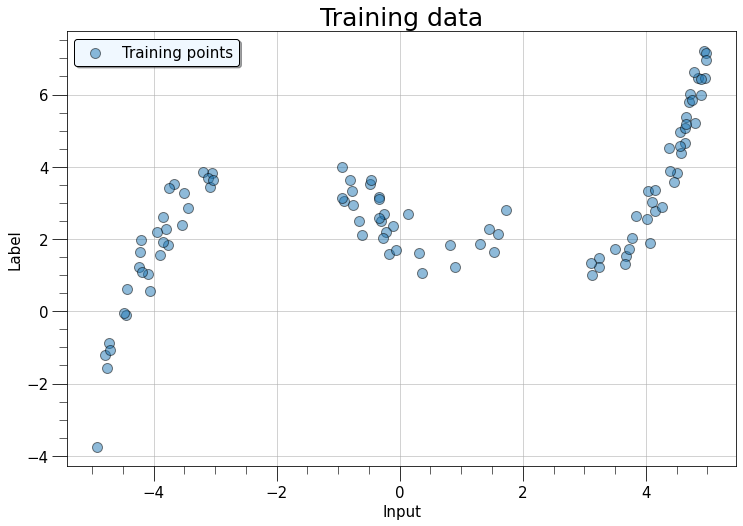

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.scatter(train_df.input, train_df.label, label='Training points', s=100, alpha=0.5,\
    edgecolor = 'black', zorder = 2)
ax.set_xlabel('Input', fontsize = 15)
ax.set_ylabel('Label', fontsize = 15)
ax.legend()
ax.grid(alpha=0.7, zorder = 1)
ax.minorticks_on()
ax.legend(shadow = True, facecolor = 'aliceblue', edgecolor='black', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15, length=15)
ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
ax.set_title('Training data', fontsize = 25)
plt.show()

# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

Download the dataset:

In [3]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

How to get an image and the corresponding label:

SAMPLE AT INDEX 0
LABEL: 9


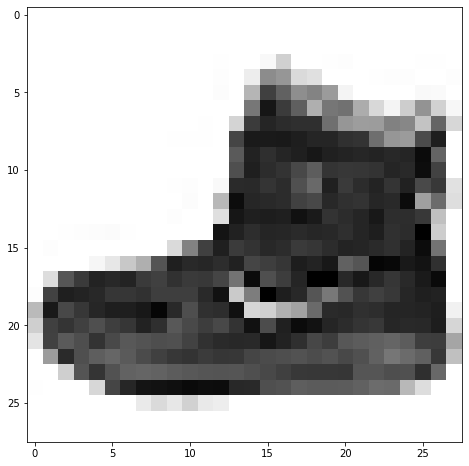

In [9]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [10]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [11]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


# Regression task

Here we start the regression part of the homework, we try to fine tune our neural network trough a k-fold cross validation. Given the relatively easy nature of our task we put care (also in the classification task) in challenging our net, not having too many parameters making the cross validation some way meaningful.

In [5]:
test_df = pd.read_csv('regression_dataset/test_data.csv')
test_df.head()

,input,label
0,-0.623168,2.908782
1,4.613433,4.961119
2,4.233314,3.403159
3,-4.555919,-0.606397
4,2.894684,1.397028


## Network definition

In this section we set a manual seed and define the network that takes in input the architecture and the activation function in order to give the net different ones in the cross validation.
The network is thought to be a standard feed-forward neural network with a non linear function as the activation.

In order to make a class flexible enough we use *Python* *OrderedDict* object.

In [6]:
torch.manual_seed(123)

In [7]:
class Net(nn.Module):
    
    def __init__(self, architecture, activation):
        
        self.ord_dict = OrderedDict([])
        for i, number in enumerate(architecture[:-1]):
            if i != 0:
                self.ord_dict.update({f'activation_{i}': \
                    activation})
            self.ord_dict.update({f'linear_{i}': \
                nn.Linear(in_features=architecture[i], out_features=architecture[i+1])})
        
        super().__init__()
        self.neural_net = nn.Sequential(
            self.ord_dict
        )
        
        
        
    def forward(self, x, additional_out=False): # x is basically the input
        x = self.neural_net(x)
        return x

## Dataset class and data transformation

In the next cell we define a standard Dataset class that reads the data into a Pandas DataFrame, we then use a lambda function to transform our dataset elements into *Pytorch* tensors.

In [8]:
class RegressionDataset(Dataset):

    def __init__(self, data, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # To read the file we use the pandas read_csv method
        self.df = pd.DataFrame(data)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        sample = (row.input, row.label)
        if self.transform:
            sample = self.transform(sample)
        return sample

In [9]:
train_dataset = RegressionDataset(train_df, transform= \
    lambda x: (torch.Tensor([x[0]]).float(),torch.Tensor([x[1]]).float()))


# Verifying if the transformation went smooth
train_dataset[0]

(tensor([-4.7879]), tensor([-1.2168]))

## Dataloader
The DataLoader function is used to divide our data into batches, the fact that it returns an iterable also comes in handy.<br> 
In the following cell we test the DataLoader function, we transform each batch into a *Pandas* dataframe only for visual purposes.<br>
The choice of the **batch size**, that will be set to 4 troughout the whole regression task, has been made with an educated guess. It's value should be better fine tuned in the cross validation part of the notebook. Not to make the computational burn too high, as it will be discussed in the following, the **batch size** parameter is not investigated further.

In [10]:
for i_batch, sample_batched in enumerate(DataLoader(train_dataset, batch_size=4, shuffle=False)):
    print(f'BATCH {i_batch}\n')
    x_batch = sample_batched[0]
    label_batch = sample_batched[1]
    print(f"Input data has shape: {x_batch.shape} \n")
    display(pd.DataFrame(x_batch, columns = ['Samples']))
    print(f"Labels (shape: {label_batch.shape})\n")
    display(pd.DataFrame(label_batch, columns = ['Samples']))
    if i_batch == 1: break 

BATCH 0

Input data has shape: torch.Size([4, 1]) 



,Samples
0,-4.787870
1,-3.509057
2,-3.855373
3,-4.083518


Labels (shape: torch.Size([4, 1]))



,Samples
0,-1.216804
1,3.277581
2,2.621375
3,1.046088


BATCH 1

Input data has shape: torch.Size([4, 1]) 



,Samples
0,-4.230588
1,-4.452022
2,-3.664075
3,-4.209050


Labels (shape: torch.Size([4, 1]))



,Samples
0,1.228874
1,-0.115171
2,3.534664
3,1.979337


## Cross validation
In this part of the Notebook we perform the cross validation for the regression task, we choose this method over using a validation set mainly because the data is not plentiful.<br> We first retrieve the indexes useful for the cross validation thanks to the *sklearn*'s *Kfold* function, defining 5 folds and shuffling the data.<br> 
The first thought was to explore more options that the one actually implemented but the initial idea was dialed back just a little in order to avoid too high computational burden. For example the effect of dropout, that in principle should be inspected, is not treated also for the very low number of neurons.
We optimized the following parameters:

- Architecture: we test 2 different architectures, a deeper one and a wider one. In order to make the competition fair we put effort in defining 2 architectures with a similar number of parameters.<br> Furthermore we try to keep the number of parameters low to make the cross validation as meaningful as possible. As it can be seen in the below cells the deeper architecture has $136$ parameters and the wider one $141$.

- Activation function: There were two classes of activation functions tested, a smooth one including the sigmoid function and one containing two similar non differentiable functions, which are ReLU and LeakyReLU. Initially the hyperbolic tangent were to be tested but was one of the options we chose not to run to reduce computational complexity and also because the hyperbolic tangent is a shifted sigmoid.

- Regularization: 3 kind of regularizations are included in the cross validation, L1 is the first, L2 the second and a combination of L1 and L2 the third. The case with no regularization added is also treated and the L1 and L2 weights have been kept fixed.

- Optimizer: The optimizers we inquire on are Adam, RMSprop, and standard SGD with momentum. The momentum hyperparameter that, if we would've stayed true to form, should be further looked into, has been kept fixed at 0.9.

- Learning rate: We try 3 different values for the learning rate parameter of the optimizers, a small one points at more stable and slower convergence but a low probability of escaping local minima.<br>
    A higher one implies a faster and more unstable convergence but a higher probability of escaping local minima. 





In [21]:
n_folds = 5
kf = KFold(n_splits = n_folds, shuffle = True, random_state = 123)

In the following cell we print the number of parameters for each network

In [24]:
net1 = Net([1, 5, 5, 5, 5, 5, 1], nn.ReLU())
net2 = Net([1, 10, 10, 1], nn.ReLU())
print('Number of parameters of the first architecture:', sum([p.numel() for p  in net1.parameters()]))
print('Number of parameters of the second architecture:',sum([p.numel() for p  in net2.parameters()]))

Number of parameters of the first architecture: 136
Number of parameters of the second architecture: 141


In [11]:
#losses = {'MSE':nn.MSELoss(), 'L1': nn.L1Loss(), 'Huber': nn.HuberLoss(delta =1.0)}
activations = {'Sigmoid': nn.Sigmoid(), 'ReLU':nn.ReLU(), 'LeakyReLU':nn.LeakyReLU(), \
   }# 'tanh':nn.Tanh()}
regularizations = ['L1', 'L2', 'L1&L2', 'None']
l1_weights = [1e-3]#, 1e-4, 1e-2, 1e-1]
l2_weights = [1e-3]#, 1e-4, 1e-2, 1e-1]
learning_rates = [1e-3, 1e-4, 1e-2]
optimizers = ['Adam', 'RMSprop', 'SGD_with_momentum']#, 'SGD']
architecures = {'Long':[1, 5, 5, 5, 5, 5, 1], 'Wide': [1, 10, 10, 1]}

## Loss 
For the regression we do not use the standard **Mean Squared Error** but we instead rely on the *L1* loss.<br> 
That's dictated a little bit by the will of changing the standard choice of the loss but, above all, by the fact that the *L1* loss penalizes many small errors and the **Mean Squared error** penalizes a few big errors. <br>
Looking at the data we see how they are fairly clustered together and do not seem to have significant outliers suggesting that the choice of the *L1* loss might be justified.

Furthermore in this loop we keep the DataLoader shuffle option to false also for the training data because we have shuffled the fold indexes.<br>
Once the best set of hyper-parameters is chosen and the final training loop will be implemented, we will set shuffle to True.

In [31]:
### TRAINING LOOP
num_epochs = 50
fold_losses = []
train_loss_log = {}
val_loss_log = {}

l1_loss = nn.L1Loss()

for activation_ in list(activations.keys()):   
    for reg in regularizations:
        for l1 in l1_weights:
            for l2 in l2_weights:
                for lr in learning_rates:
                    for optimizer_ in optimizers:
                        for architecture_ in list(architecures.keys()):
                            print((activation_, reg, l1, l2, lr, optimizer_, architecture_))
                            train_loss_log[(activation_, reg, l1, l2, lr, optimizer_, architecture_)] = {}
                            val_loss_log[(activation_, reg, l1, l2, lr, optimizer_, architecture_)] = {}
                            fold_index = 0

                            #print((loss_, activation_, reg, l1, l2, lr, optimizer))
                            for train_idx, val_idx in kf.split(np.array(train_df)):
                            
                                net = Net(architecures[architecture_], activations[activation_])
                                if optimizer_ == 'Adam':
                                    optimizer = optim.Adam(net.parameters(), lr=lr)
                                elif optimizer_ == 'RMSprop':
                                    optimizer = optim.RMSprop(net.parameters(), lr=lr)

                                elif optimizer_ == 'SGD_with_momentum':
                                    optimizer = optim.SGD(net.parameters(), lr=lr, momentum = 0.9)
                                fold_index += 1
                                
                                train_loss_log[(activation_, reg, l1, l2, lr, optimizer_, architecture_)][f'fold_{fold_index}'] = []
                                train_sample = RegressionDataset(train_df.iloc[train_idx], transform= \
                                lambda x: (torch.Tensor([x[0]]).float(),torch.Tensor([x[1]]).float()))

                                val_loss_log[(activation_, reg, l1, l2, lr, optimizer_, architecture_)][f'fold_{fold_index}'] = []
                                validation_sample = RegressionDataset(train_df.iloc[val_idx], transform= \
                                lambda x: (torch.Tensor([x[0]]).float(),torch.Tensor([x[1]]).float()))

                                train_data = DataLoader(train_sample, batch_size=4, shuffle=False)
                                validation_data = DataLoader(validation_sample, batch_size=len(validation_sample), shuffle=False)
                                
                                for epoch_num in range(num_epochs):
                                    

                                    ### TRAIN
                                    train_loss= []
                                    net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
                                    for sample_batched in train_data:

                                        
                                        x_batch = sample_batched[0]
                                        label_batch = sample_batched[1]
                                        
                                        # Forward pass
                                        out = net(x_batch)

                                        # Compute loss
                                        loss_fn = l1_loss
                                        
                                        loss = loss_fn(out, label_batch)
                                        
                                        l1_penalty = l1 * sum([p.abs().sum() for name, p in net.named_parameters()\
                                            if 'bias' not in name])
                                        l2_penalty = l2 * sum([(p**2).sum() for name, p in net.named_parameters()\
                                            if 'bias' not in name])
                                        
                                        if reg == 'L1':
                                            loss += l1_penalty 
                                        elif reg == 'L2':
                                            loss += + l2_penalty 
                                        elif reg == 'L2':
                                            loss += + l2_penalty + l1_penalty
                                        # Backpropagation
                                        net.zero_grad()
                                        loss.backward()

                                        # Update the weights
                                        optimizer.step()

                                        # Save train loss for this batch
                                        loss_batch = loss.detach().cpu().numpy() # we detach it from the computational graph
                                        train_loss.append(loss_batch)

                                    # Save average train loss
                                    train_loss = np.mean(train_loss)
                                    
                                    
                                    train_loss_log[( activation_, reg, l1, l2, lr, optimizer_, architecture_)][f'fold_{fold_index}']\
                                        .append(train_loss)

                                    ### VALIDATION
                                    
                                    val_loss= []
                                    net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
                                    with torch.no_grad(): # Disable gradient tracking, we don't want to update the weights
                                        for sample_batched in validation_data:
                                            

                                            x_batch = sample_batched[0]
                                            
                                            label_batch = sample_batched[1]
                                            
                                            # Forward pass
                                            
                                            out = net(x_batch)
                                
                                            # Compute loss
                                            loss_fn = l1_loss
                                            
                                            loss = loss_fn(out, label_batch)

                                            if reg == 'L1':
                                                loss += + l1_penalty 
                                            elif reg == 'L2':
                                                loss += + l2_penalty 
                                            elif reg == 'L2':
                                                loss += + l2_penalty + l1_penalty

                                            # Save val loss for this batch
                                            loss_batch = loss.detach().numpy()
                                            val_loss.append(loss_batch)

                                        # Save average validation loss
                                        val_loss = np.mean(val_loss)
                                        #print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
                                        val_loss_log[(activation_, reg, l1, l2, lr, optimizer_, architecture_)][f'fold_{fold_index}']\
                                            .append(val_loss)

                            

('Sigmoid', 'L1', 0.001, 0.001, 0.001, 'Adam', 'Long')
('Sigmoid', 'L1', 0.001, 0.001, 0.001, 'Adam', 'Wide')
('Sigmoid', 'L1', 0.001, 0.001, 0.001, 'RMSprop', 'Long')
('Sigmoid', 'L1', 0.001, 0.001, 0.001, 'RMSprop', 'Wide')
('Sigmoid', 'L1', 0.001, 0.001, 0.001, 'SGD_with_momentum', 'Long')
('Sigmoid', 'L1', 0.001, 0.001, 0.001, 'SGD_with_momentum', 'Wide')
('Sigmoid', 'L1', 0.001, 0.001, 0.0001, 'Adam', 'Long')
('Sigmoid', 'L1', 0.001, 0.001, 0.0001, 'Adam', 'Wide')
('Sigmoid', 'L1', 0.001, 0.001, 0.0001, 'RMSprop', 'Long')
('Sigmoid', 'L1', 0.001, 0.001, 0.0001, 'RMSprop', 'Wide')
('Sigmoid', 'L1', 0.001, 0.001, 0.0001, 'SGD_with_momentum', 'Long')
('Sigmoid', 'L1', 0.001, 0.001, 0.0001, 'SGD_with_momentum', 'Wide')
('Sigmoid', 'L1', 0.001, 0.001, 0.01, 'Adam', 'Long')
('Sigmoid', 'L1', 0.001, 0.001, 0.01, 'Adam', 'Wide')
('Sigmoid', 'L1', 0.001, 0.001, 0.01, 'RMSprop', 'Long')
('Sigmoid', 'L1', 0.001, 0.001, 0.01, 'RMSprop', 'Wide')
('Sigmoid', 'L1', 0.001, 0.001, 0.01, 'SGD_with_

In [35]:
with open('val_loss_log.txt', mode = 'w') as f:
    f.write(str(val_loss_log))

In [36]:
for key in list(val_loss_log.keys()):
    val_loss_log[key]['fold_1'] = val_loss_log[key]['fold_1'][-1]
    val_loss_log[key]['fold_2'] = val_loss_log[key]['fold_2'][-1]
    val_loss_log[key]['fold_3'] = val_loss_log[key]['fold_3'][-1]
    val_loss_log[key]['fold_4'] = val_loss_log[key]['fold_4'][-1]
    val_loss_log[key]['fold_5'] = val_loss_log[key]['fold_5'][-1]

In [37]:
for key in list(val_loss_log.keys()):
    val_loss_log[key] = np.mean(list(val_loss_log[key].values()))

In [61]:
filtered_keys = list(map(lambda x:x.replace(')', '').replace('(', '').split(','),list(val_loss_log.keys())))

In [63]:
df_cv = pd.DataFrame(filtered_keys, columns = ['Activation', \
   'Regularization', 'l1_weight', 'l2_weight', 'learning_rate', 'Optimizer', 'Architecture' ])
df_cv['Loss_value'] = list(val_loss_log.values())

## Cross validation results
In the below *Pandas* DataFrame we show the results of the *Kfold* cross validation, more specifically we display the top 20 models found. <br>
The 3 parameters that seem to influence in a greater way the performance of the model, that are also the ones further investigated in the plots are:

- Learning rate: We can notice how the whole top 20 models set has 0.01 as the learning rate value.

- Activation function: There isn't a clear cut choice here but we can clearly see how the top architectures have either ReLU or LeakyReLU.<br> 
    The fact that one or the other does not prevail makes sense as they are similar functions. It's important to notice though how they perform better than the Sigmoid function.

- Optimizer: We see interestingly that the top models use RMSprop as an optimizer and only 1 of the top 20 model exploits SGD with momentum.

As far as the regularization and the specific architecture at first glance they don't seem to overly impact the performances.



In [47]:
df_cv = df_cv.sort_values(by='Loss_value')
df_cv.iloc[0:20]

,Activation,Regularization,l1_weight,l2_weight,learning_rate,Optimizer,Architecture,Loss_value
0,'LeakyReLU','L1&L2',0.001,0.001,0.010,'RMSprop','Wide',0.726004
1,'LeakyReLU','None',0.001,0.001,0.010,'RMSprop','Long',0.763060
2,'LeakyReLU','L2',0.001,0.001,0.010,'RMSprop','Wide',0.764306
3,'LeakyReLU','None',0.001,0.001,0.010,'RMSprop','Wide',0.764969
4,'ReLU','None',0.001,0.001,0.010,'RMSprop','Wide',0.772312
5,'LeakyReLU','L1&L2',0.001,0.001,0.010,'RMSprop','Long',0.772365
6,'ReLU','L1&L2',0.001,0.001,0.010,'RMSprop','Wide',0.846824
7,'LeakyReLU','L2',0.001,0.001,0.010,'RMSprop','Long',0.880941
8,'ReLU','L1',0.001,0.001,0.010,'RMSprop','Wide',0.929475
9,'ReLU','L2',0.001,0.001,0.010,'RMSprop','Long',0.940380


In [68]:
df_cv.to_csv('kf_val_loss.csv', index=False)

In [12]:
df_cv = pd.read_csv('kf_val_loss.csv')

In [118]:
navy_patch = mpatches.Patch(color='navy')
forestgreen_patch = mpatches.Patch(color='forestgreen')
firebrick_patch = mpatches.Patch(color='firebrick')

## Graphical representation
In the 3 plots below we can see the performances of all the architectures implemented with a zoom on the top 50 models.<br>

Interestingly we can notice how the vast majority of the worst models have a 0.0001 learning rate, this suggests that in those cases either the optimizer is too slow and doesn't converges or the system settles into a local minima.

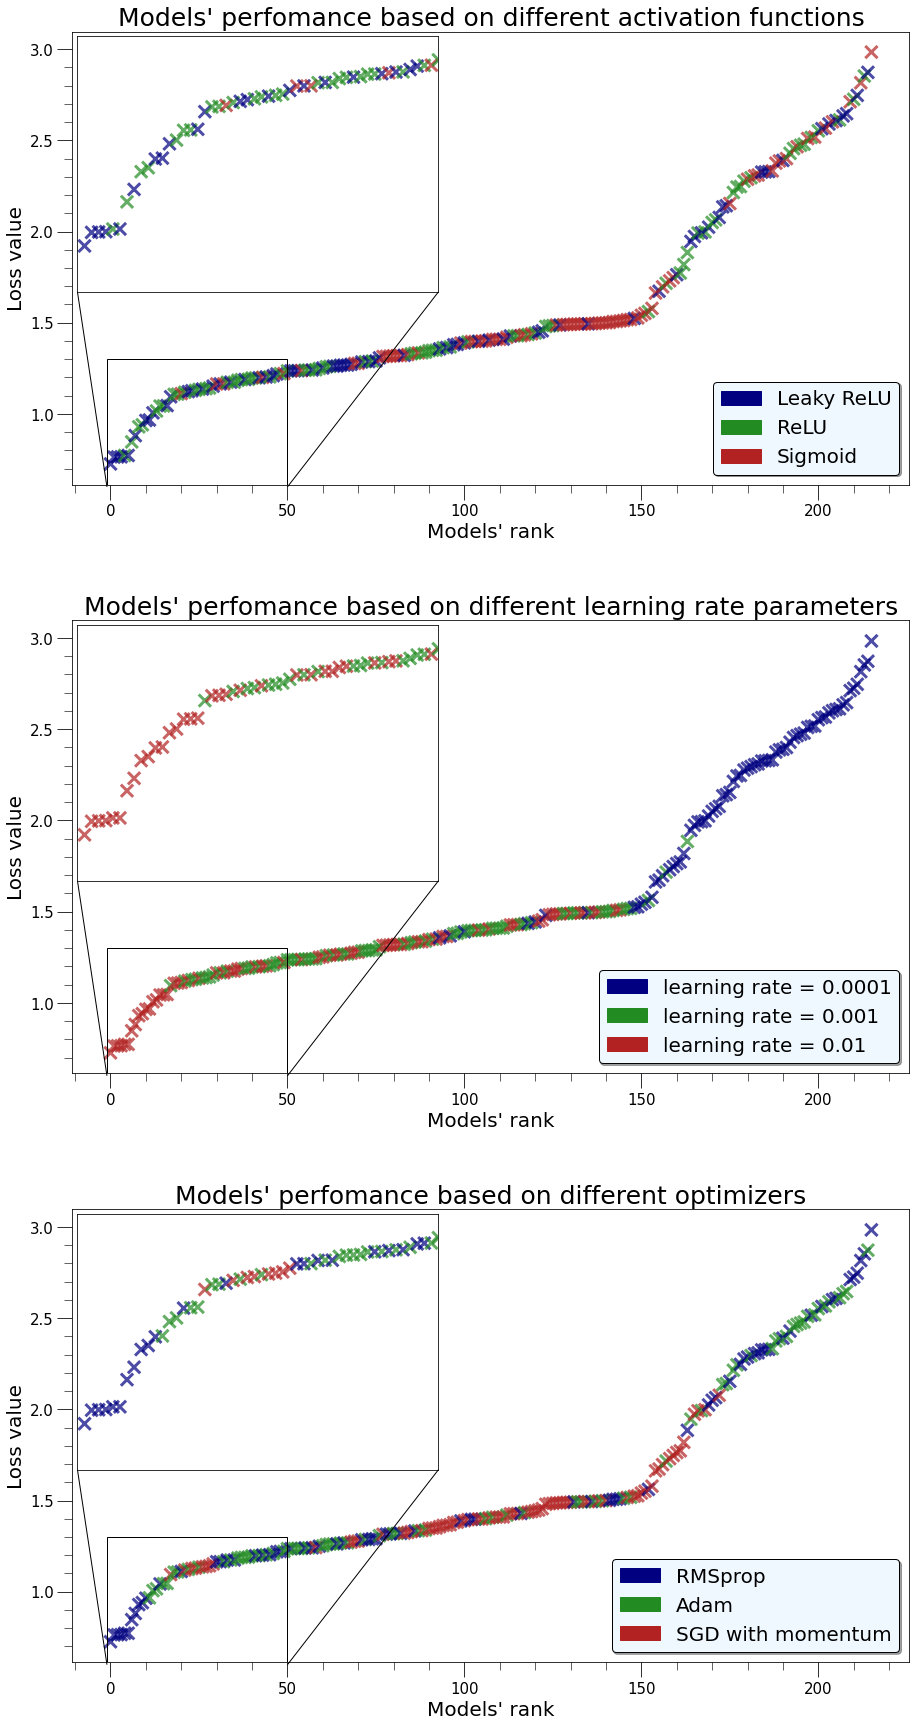

In [196]:
fig, ax = plt.subplots(3, 1,  figsize = (15, 30))

ax1, ax2, ax3 = ax

sns.scatterplot(x = df_cv.index, y = df_cv['Loss_value'], hue = df_cv['Activation'], ax = ax1, \
    s = 150, alpha = 0.7, marker = 'x', linewidth = 3, palette = ['navy', 'forestgreen', 'firebrick'])

ax1.legend(handles = [navy_patch, forestgreen_patch, firebrick_patch],\
        labels=['Leaky ReLU', 'ReLU', 'Sigmoid'], \
                fontsize = 20, edgecolor= 'black', facecolor='aliceblue', shadow = True, \
                        loc = 'lower right')

ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=15, length=15)
ax1.tick_params(axis='both', which='minor', labelsize=15, length=8)

axins1 = zoomed_inset_axes(ax1, zoom = 2, loc='upper left',) # zoom = 2
x1, x2 = -1, 50
y1, y2 = 0.6, 1.3
axins1.set_xlim(x1, x2)
axins1.set_ylim(y1, y2)
axins1.set_xticks([])
axins1.set_yticks([])

sns.scatterplot(x = df_cv.index, y = df_cv['Loss_value'], hue = df_cv['Activation'], ax = axins1, \
    s = 150, alpha = 0.7, marker = 'x', linewidth = 3, palette = ['navy', 'forestgreen', 'firebrick'], \
        legend = False)

mark_inset(ax1, axins1, loc1=3, loc2=4, fc="none", ec="0")



sns.scatterplot(x = df_cv.index, y = df_cv['Loss_value'], hue = df_cv['learning_rate'], ax = ax2, \
    s = 150, alpha = 0.7, marker = 'x', linewidth = 3, \
        palette = ['navy', 'forestgreen', 'firebrick'])

ax2.legend(handles = [navy_patch, forestgreen_patch, firebrick_patch],\
        labels=['learning rate = 0.0001', 'learning rate = 0.001', 'learning rate = 0.01'], \
                fontsize = 20, edgecolor= 'black', facecolor='aliceblue', shadow = True, \
                        loc = 'lower right')

axins2 = zoomed_inset_axes(ax2, zoom = 2, loc='upper left',) # zoom = 2
x1, x2 = -1, 50
y1, y2 = 0.6, 1.3
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)
axins2.set_xticks([])
axins2.set_yticks([])

sns.scatterplot(x = df_cv.index, y = df_cv['Loss_value'], hue = df_cv['learning_rate'], ax = axins2, \
    s = 150, alpha = 0.7, marker = 'x', linewidth = 3, \
        palette = ['navy', 'forestgreen', 'firebrick'], legend = False)

mark_inset(ax2, axins2, loc1=3, loc2=4, fc="none", ec="0")


ax2.minorticks_on()
ax2.tick_params(axis='both', which='major', labelsize=15, length=15)
ax2.tick_params(axis='both', which='minor', labelsize=15, length=8)



sns.scatterplot(x = df_cv.index, y = df_cv['Loss_value'], hue = df_cv['Optimizer'], ax = ax3, \
    s = 150, alpha = 0.7, marker = 'x', linewidth = 3, palette = ['navy', 'forestgreen', 'firebrick'])
navy_patch = mpatches.Patch(color='navy')
forestgreen_patch = mpatches.Patch(color='forestgreen')
firebrick_patch = mpatches.Patch(color='firebrick')
ax3.legend(handles = [navy_patch, forestgreen_patch, firebrick_patch],\
        labels=['RMSprop', 'Adam', 'SGD with momentum'], \
                fontsize = 20, edgecolor= 'black', facecolor='aliceblue', shadow = True, \
                    loc = 'lower right')


ax3.minorticks_on()
ax3.tick_params(axis='both', which='major', labelsize=15, length=15)
ax3.tick_params(axis='both', which='minor', labelsize=15, length=8)

axins3 = zoomed_inset_axes(ax3, zoom = 2, loc='upper left',) # zoom = 2
x1, x2 = -1, 50
y1, y2 = 0.6, 1.3
axins3.set_xlim(x1, x2)
axins3.set_ylim(y1, y2)
axins3.set_xticks([])
axins3.set_yticks([])

sns.scatterplot(x = df_cv.index, y = df_cv['Loss_value'], hue = df_cv['Optimizer'], ax = axins3, \
    s = 150, alpha = 0.7, marker = 'x', linewidth = 3, palette = ['navy', 'forestgreen', 'firebrick'],\
        legend = False)

mark_inset(ax3, axins3, loc1=3, loc2=4, fc="none", ec="0")



for ax_ in ax:
    ax_.set_ylabel('Loss value', fontsize = 20)
    ax_.set_xlabel('Models\' rank', fontsize = 20)

ax1.set_title('Models\' perfomance based on different activation functions', fontsize = 25)
ax2.set_title('Models\' perfomance based on different learning rate parameters', fontsize = 25)
ax3.set_title('Models\' perfomance based on different optimizers', fontsize = 25)

fig.subplots_adjust(hspace=0.3)




## Final model 
In this section we select our top model, we train it and we verify its performances with the test dataset. <br>

As far as the number of epochs are concerned, we define an upper limit at 3000 but we stop the training after 300 epochs that do not improve the test loss.

In [13]:
final_train_sample = RegressionDataset(train_df, transform= \
                                lambda x: (torch.Tensor([x[0]]).float(),torch.Tensor([x[1]]).float()))
# Now we shuffle
final_train_data = DataLoader(final_train_sample, batch_size=4, shuffle=True)

final_test_sample = RegressionDataset(test_df, transform= \
                                lambda x: (torch.Tensor([x[0]]).float(),torch.Tensor([x[1]]).float()))
# Now we shuffle
final_test_data = DataLoader(final_test_sample, batch_size=len(final_test_sample), shuffle=False)

In [14]:
final_model = Net(architecures['Wide'], activation=activations['LeakyReLU'])

In [15]:
final_optimizer = optim.RMSprop(final_model.parameters(), lr = 0.01)


In [31]:
### TRAINING LOOP
num_epochs = 3000
train_loss_log = []
val_loss_log = []
non_improving = 0
val_loss_mean = np.Inf
epoch_num = 0
while non_improving < 300:
    epoch_num += 1
#for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    # TRAIN
    train_loss= []
    final_model.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
    for sample_batched in final_train_data:
        
        x_batch = sample_batched[0]
        label_batch = sample_batched[1]

        # Forward pass
        out = final_model(x_batch)
        l1_penalty = 1e-3 * sum([p.abs().sum() for name, p in final_model.named_parameters()\
                                            if 'bias' not in name])
        l2_penalty = 1e-3 * sum([(p**2).sum() for name, p in final_model.named_parameters()\
            if 'bias' not in name])
        # Compute loss
        loss = l1_loss(out, label_batch)

        loss += l1_penalty + l2_penalty
        # Backpropagation
        final_model.zero_grad()
        loss.backward()

        # Update the weights
        final_optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().numpy() # we detach it from the computational graph
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    val_loss= []
    final_model.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking, we don't want to update the weights
        for sample_batched in final_test_data:
            
            x_batch = sample_batched[0]
            label_batch = sample_batched[1]
            
            # Forward pass
            out = final_model(x_batch)
            l1_penalty = 1e-3 * sum([p.abs().sum() for name, p in final_model.named_parameters()\
                                            if 'bias' not in name])
            l2_penalty = 1e-3 * sum([(p**2).sum() for name, p in final_model.named_parameters()\
                if 'bias' not in name])
            # Compute loss
            loss = l1_loss(out, label_batch)

            loss += l1_penalty + l2_penalty

            

            # Save val loss for this batch
            loss_batch = loss.detach().numpy()
            val_loss.append(loss_batch)

        # Save average validation loss
        if np.mean(val_loss) > val_loss_mean:
            non_improving +=1
        val_loss_mean = np.mean(val_loss)
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss_mean)}")
        val_loss_log.append(val_loss_mean)
    


#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 1.2882896661758423
AVERAGE VAL LOSS: 1.2755314111709595
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 1.3256553411483765
AVERAGE VAL LOSS: 1.1579196453094482
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 1.2740097045898438
AVERAGE VAL LOSS: 1.1495767831802368
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 1.3313353061676025
AVERAGE VAL LOSS: 1.0935581922531128
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 1.3064210414886475
AVERAGE VAL LOSS: 1.099608302116394
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 1.1701736450195312
AVERAGE VAL LOSS: 1.1054426431655884
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 1.180814266204834
AVERAGE VAL LOSS: 0.9769477248191833
#################
# EPOCH 8
#################
AVERAGE TRAIN LOSS: 1.1767830848693848
AVERAGE VAL LOSS: 1.133020043373108
#################
# EPOCH 9

In [32]:
print(epoch_num)

614


<center>

| Number of epochs | Training Loss | Test Loss |
|:----------------:|:-------------:|-----------|
|        614       |      0.49     |    0.45   |


</center>

In [33]:
net_state_dict = final_model.state_dict()
print(net_state_dict.keys())
# Save the state dict to a file
torch.save(net_state_dict, 'net_parameters.torch')

odict_keys(['neural_net.linear_0.weight', 'neural_net.linear_0.bias', 'neural_net.linear_1.weight', 'neural_net.linear_1.bias', 'neural_net.linear_2.weight', 'neural_net.linear_2.bias'])


## Training and test loss progression

From the test and training loos progression we can see that the network seems to have good generalization properties.<br> 
The test error is infact close to the training even though it is much more unstable.

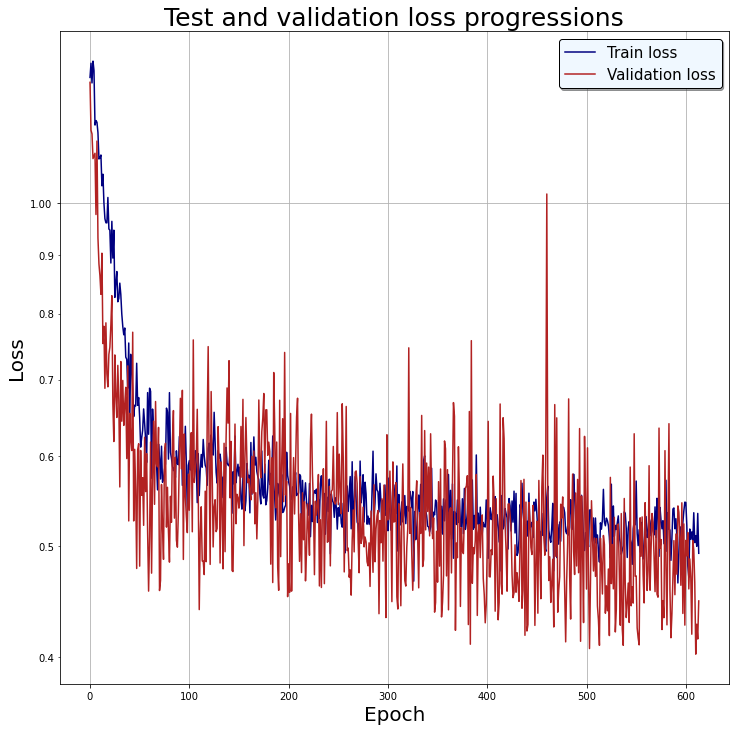

In [67]:
from matplotlib.ticker import ScalarFormatter
# Plot losses
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.semilogy(train_loss_log, label='Train loss', color='navy')
ax.semilogy(val_loss_log, label='Validation loss', color='firebrick')
ax.get_yaxis().set_major_formatter(ScalarFormatter())
ax.get_yaxis().set_minor_formatter(ScalarFormatter())
ax.set_title('Test and validation loss progressions', fontsize = 25)
ax.set_xlabel('Epoch', fontsize = 20)
ax.set_ylabel('Loss', fontsize = 20)
ax.grid()
ax.legend(fontsize = 15, facecolor = 'aliceblue', shadow = True, edgecolor = 'black')

plt.show()

In [18]:
net_state_dict = torch.load('net_parameters.torch')
# Update the network parameters
final_model.load_state_dict(net_state_dict)

<All keys matched successfully>

In [19]:
# Input vector
x_vec = torch.linspace(-5,5,1000)

x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector to have 1000 samples of size 1
print(f"Input shape: {x_vec.shape}")

# Network output

final_model.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = final_model(x_vec)
print(f"Output shape: {y_vec.shape}")




Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


## Network output
In the plot below we test the Network prediction. We can conclude that for the number of parameters that the net has, it performs fairly well.<br>

The line representing the model output generalizes good enough to the test set with the exception of a narrow window at around x = 2.<br>
The network output is far from smooth and that's given by the choice of the activation function, the choice of a **Sigmoid** or of a **Hyperbolic tangent** would have caused a way smoother output. <br>
We have though that the first network inspected in the cross validation with a **Sigmoid** activation function is not able to fit the curve in a satisfying way, pointing at the fact that we might need more parameters or a better overall implementation to use the **Sigmoid** as an activation function.

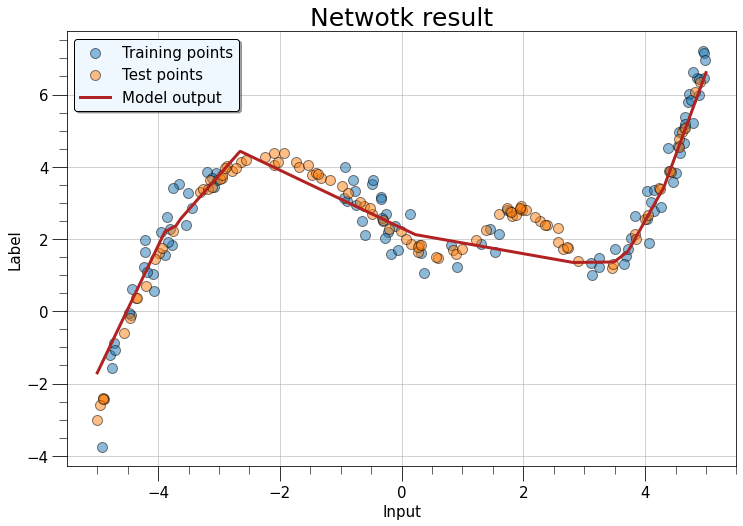

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.scatter(train_df.input, train_df.label, label='Training points', s=100, alpha=0.5,\
    edgecolor = 'black', zorder = 2)
ax.scatter(test_df.input, test_df.label, label='Test points', s=100, alpha=0.5,\
    edgecolor = 'black', zorder = 2)
ax.set_xlabel('Input', fontsize = 15)
ax.set_ylabel('Label', fontsize = 15)
ax.legend()
ax.plot(x_vec, y_vec, color = 'firebrick', label = 'Model output', linewidth = 3)
ax.grid(alpha=0.7, zorder = 1)
ax.minorticks_on()
ax.legend(shadow = True, facecolor = 'aliceblue', edgecolor='black', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15, length=15)
ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
ax.set_title('Netwotk result', fontsize = 25)
plt.show()

## Weight's distribution

Through histograms we visualize the weight's distribution. For all the 3 layers the PDF it is heavily peaked around 0. 

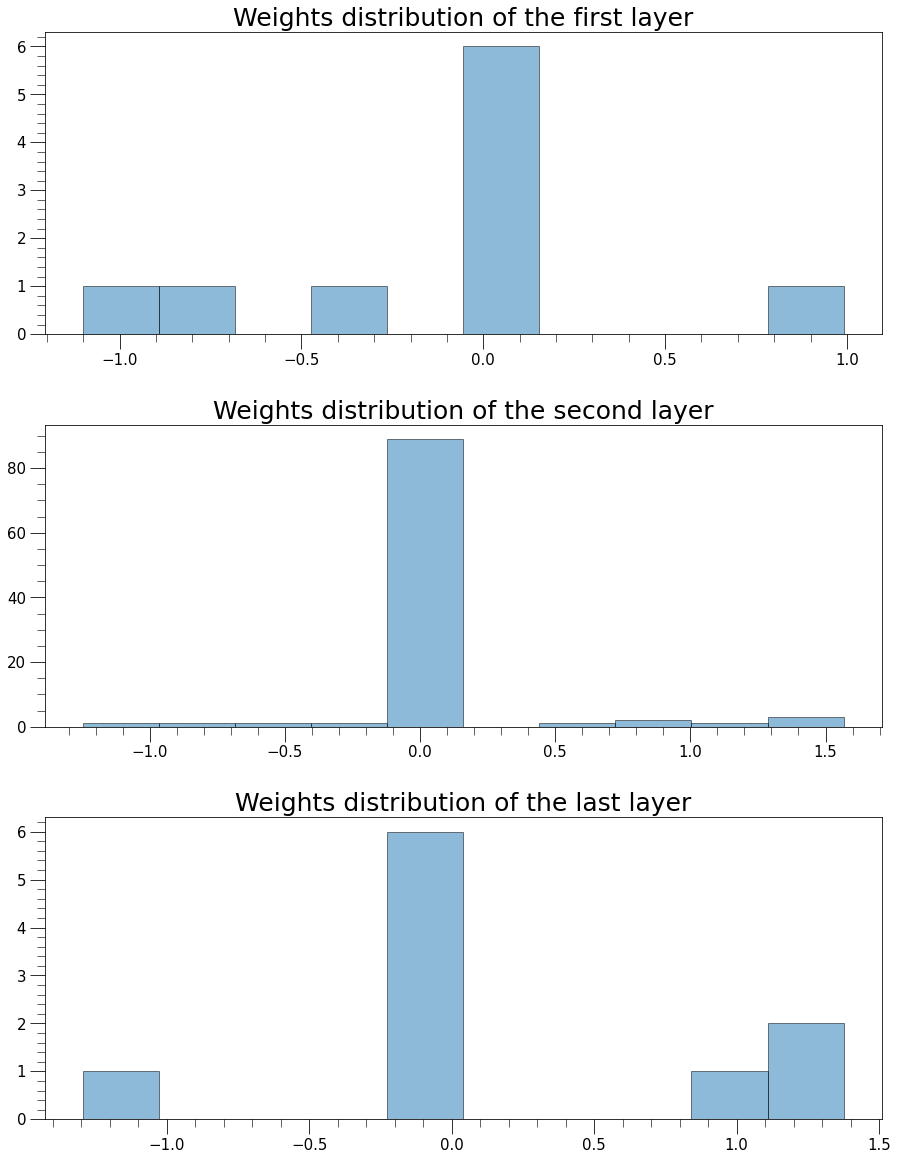

In [31]:
fig, ax = plt.subplots(3, 1, figsize = (15, 20))
ax1, ax2, ax3 = ax
ax1.set_title('Weights distribution of the first layer', fontsize = 25)
ax1.hist(final_model.neural_net.linear_0.weight.data.numpy(), alpha = 0.5, \
    edgecolor = 'black')
ax2.set_title('Weights distribution of the second layer', fontsize = 25)
ax2.hist(final_model.neural_net.linear_1.weight.data.numpy().flatten(), alpha = 0.5, \
    edgecolor = 'black')
ax3.set_title('Weights distribution of the last layer', fontsize = 25)
ax3.hist(final_model.neural_net.linear_2.weight.data.numpy().flatten(), alpha = 0.5, \
    edgecolor = 'black')


for ax_ in ax:
    ax_.minorticks_on()
    ax_.tick_params(axis='both', which='major', labelsize=15, length=15)
    ax_.tick_params(axis='both', which='minor', labelsize=15, length=8)

fig.subplots_adjust(hspace=0.3)
plt.show()

## Activation's visualization

In the following 2 cells we instead visualize the activation value for the last and the first layer of the net, for different network inputs.<br>
We try 3 different kind of input: one that is related to the upward part of the curve, another to the part that has a negative slope and the last one that is totally outside the training and test point's range.
<hr>

As far as the last layer's activation we interestingly notice that the two points inside the training point's range have a higher entropy and are pretty similar except for the opposite relation that the second and the third activation have.<br>

The point that is outside our data range is characterized by a few neurons that are maximally activated with the afore-mentioned second and third neurons that are maximally activated.<br> 
The network in this case predicts a y value around 4000 as if the positive slope of the curve would continue and it makes sense that the network makes this kind of generalization.
<hr>

Looking at the first layer we see how the positive slope and the negative slope input, differ substantially for the activations of the third through the seventh neuron. <br>
The activations in the case of the extreme point interestingly follow the pattern of the x = 4.5 case, we can make the hypothesis of how something in this pattern may somehow encode the positive slope of the curve.


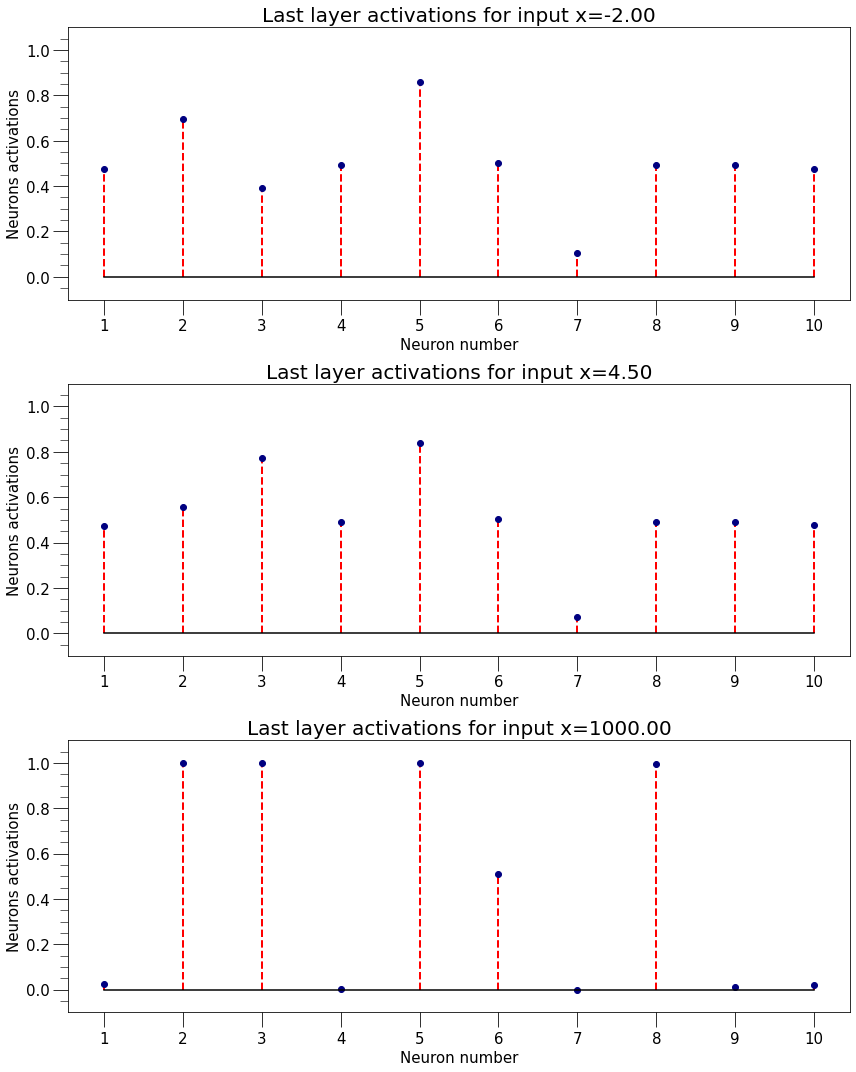

In [110]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = final_model.neural_net.linear_1.register_forward_hook(get_activation)

### Analyze activations

final_model.eval()
# We are doing th activation of the second hidden layer
with torch.no_grad():
    x1 = torch.tensor([-2]).float()
    y1 = final_model(x1)
    z1 = activation
    x2 = torch.tensor([4.5]).float()
    y2 = final_model(x2)
    z2 = activation
    x3 = torch.tensor([1000]).float()
    y3 = final_model(x3)
    z3 = activation
    

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,15))
markerline1, stemlines1, baseline1 = axs[0].stem(z1.cpu().numpy(), use_line_collection=True, linefmt = 'firebrick')
axs[0].set_title('Last layer activations for input x=%.2f' % x1, fontsize = 20)
markerline2, stemlines2, baseline2 = axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2, fontsize = 20)
markerline3, stemlines3, baseline3 = axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3, fontsize = 20)

plt.setp(stemlines1, linewidth=2, color='r', linestyle='--')
plt.setp(markerline1, color='navy')
plt.setp(baseline1, color='black')
plt.setp(stemlines2, linewidth=2, color='r', linestyle='--')
plt.setp(markerline2, color='navy')
plt.setp(baseline2, color='black')
plt.setp(stemlines3, linewidth=2, color='r', linestyle='--')
plt.setp(markerline3, color='navy')
plt.setp(baseline3, color='black')
for ax_ in axs:
    ax_.minorticks_on()
    ax_.tick_params(axis='x', which='minor', bottom=False)
    ax_.set_xticks(range(0, 10))
    ax_.set_xticklabels(range(1, 11))
    ax_.tick_params(axis='both', which='major', labelsize=15, length=15)
    ax_.tick_params(axis='both', which='minor', labelsize=15, length=8)
    ax_.set_ylim(bottom = -0.1, top = 1.1)
    ax_.set_ylabel('Neurons activations', fontsize = 15)
    ax_.set_xlabel('Neuron number', fontsize = 15)
plt.tight_layout()


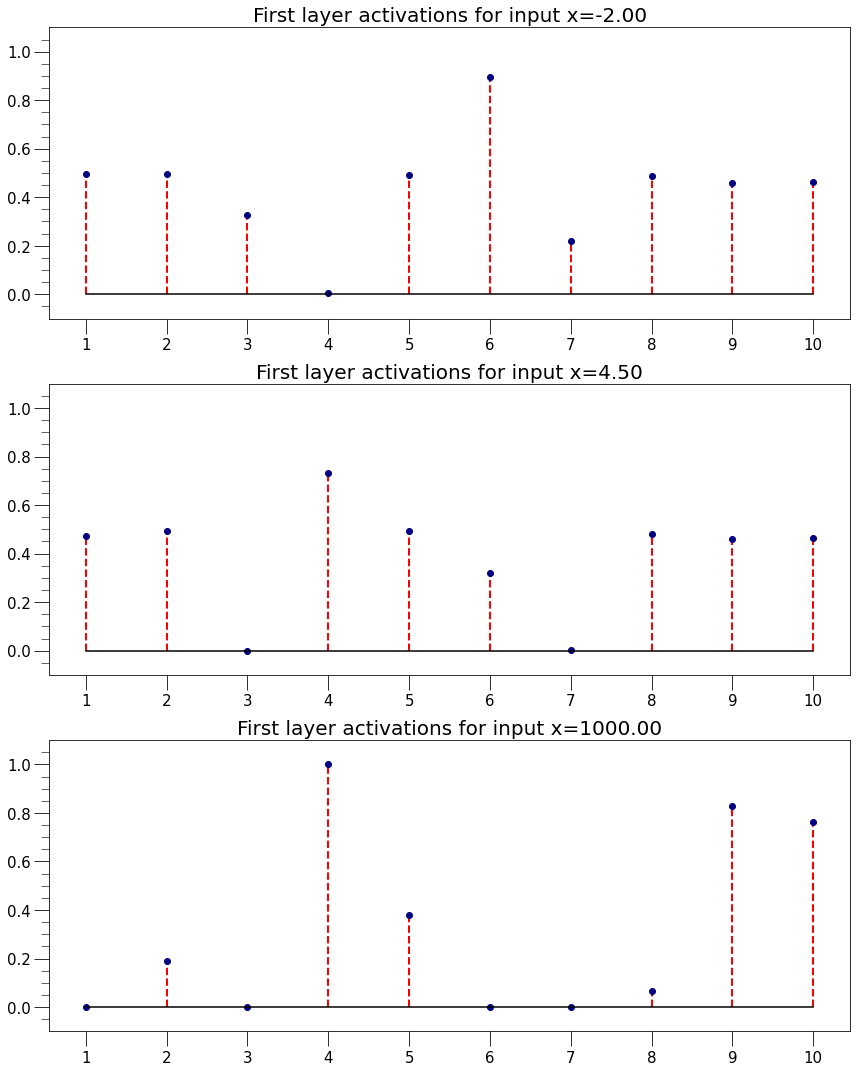

In [25]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

# Register hook  
hook_handle = final_model.neural_net.linear_0.register_forward_hook(get_activation)


# Analyze activations

final_model.eval()
# We are doing th activation of the second hidden layer
with torch.no_grad():
    x1 = torch.tensor([-2]).float()
    y1 = final_model(x1)
    z1 = activation
    x2 = torch.tensor([4.5]).float()
    y2 = final_model(x2)
    z2 = activation
    x3 = torch.tensor([1000]).float()
    y3 = final_model(x3)
    z3 = activation

# Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,15))
markerline1, stemlines1, baseline1 = axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('First layer activations for input x=%.2f' % x1, fontsize = 20)
markerline2, stemlines2, baseline2 = axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('First layer activations for input x=%.2f' % x2, fontsize = 20)
axs[0].set_ylim(bottom = -0.1, top = 1.1)
axs[2].set_title('First layer activations for input x=%.2f' % x3, fontsize = 20)
axs[0].set_ylim(bottom = -0.1, top = 1.1)
markerline3, stemlines3, baseline3 = axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[1].set_ylim(bottom = -0.1, top = 1.1)
axs[2].set_ylim(bottom = -0.1, top = 1.1)


plt.setp(stemlines1, linewidth=2, color='r', linestyle='--')
plt.setp(markerline1, color='navy')
plt.setp(baseline1, color='black')
plt.setp(stemlines2, linewidth=2, color='r', linestyle='--')
plt.setp(markerline2, color='navy')
plt.setp(baseline2, color='black')
plt.setp(stemlines3, linewidth=2, color='r', linestyle='--')
plt.setp(markerline3, color='navy')
plt.setp(baseline3, color='black')

for ax_ in axs:
    ax_.minorticks_on()
    ax_.tick_params(axis='x', which='minor', bottom=False)
    ax_.set_xticks(range(0, 10))
    ax_.set_xticklabels(range(1, 11))
    ax_.tick_params(axis='both', which='major', labelsize=15, length=15)
    ax_.tick_params(axis='both', which='minor', labelsize=15, length=8)

plt.tight_layout()

# Classification Task

Here starts the classification task's part of the notebook, we try to learn to correctly classify images from the fashion MNIST dataset. <br>
As we've done in the regression section we look for the optional hyperparameters to fine tune the model. We then train it, inspect the performances and look for a better understanding of its working.

In [33]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

### Validation set
Contrary to the regression task, here we have at our disposal much more training points. Also to make a different choice then, now that the dataset dimension allows us to, we choose to work with a validation set. 

We decide to divide the training set dedicating 20% of the data to the validation task.

In [34]:
train_set_size = int(len(train_dataset) * 0.8)
valid_set_size = len(train_dataset) - train_set_size
train_dataset, valid_dataset = data.random_split(train_dataset, [train_set_size, valid_set_size],\
    generator=torch.Generator().manual_seed(123))

Example of a training sample

Sample 0
Label: 2


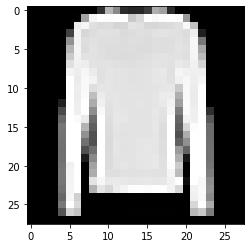

In [35]:
index = 0
image, label = train_dataset[index]
print(f"Sample {index}")
print(f"Label: {label}")
plt.imshow(image, cmap='gray')
plt.show()

## Data transformation

As far as the test data the only transformation we implement is to put it into a tensor format.

Regarding the Training data, other then setting it to tensor, we apply a couple of transformations to make the network more resilient to different data and to improve its generalization properties. 
<hr>

We implement the following:

- RandomResizedCrop: We crop the images and return an image with the same size of the original one.

- RandomVerticalFlip: With a probability of 0.2 we flip vertically the image.

- rand_noise: We define a custom class that adds to the image noise randomly sampled from a standard normal distribution that it is then rescaled.

- RandomRotation: We randomly choose an angle between -45 degrees and 45 degrees to rotate the image.



In [13]:
test_trans = transforms.Compose([
        transforms.ToTensor(), # Convert to tensor
        ])

Original image space: (28, 28)
Tranformed image space: torch.Size([1, 28, 28])
<class 'torch.Tensor'>


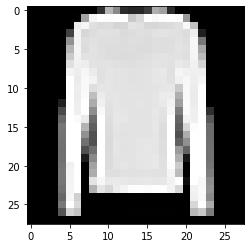

In [37]:
original_image = train_dataset[0][0]
transformed_image = test_trans(original_image)
print(f"Original image space: {np.array(original_image).shape}")
print(f"Tranformed image space: {transformed_image.shape}")
# Verifying we have a tensor
print(type(transformed_image))
plt.imshow(transformed_image.squeeze(), cmap='gray')
plt.show()

In [38]:
class rand_noise(object):
        
    def __call__(self, image):
        self.random = torch.rand_like(torch.tensor(np.zeros((28, 28))))
        return image + self.random/10

In [39]:
# Train transformation pipeline

train_trans = transforms.Compose([
        # This resize the image, but keep the proportion
        transforms.RandomRotation([-45, 45]),
        
        transforms.RandomResizedCrop(size = 28, scale=(0.9, 1)),
        transforms.RandomVerticalFlip(p=0.2),
        # This apply a random rotation to the image
        transforms.ToTensor(),
        rand_noise()
        
        ])

Original image shape: (28, 28)
transformed shape: torch.Size([1, 28, 28])
Original


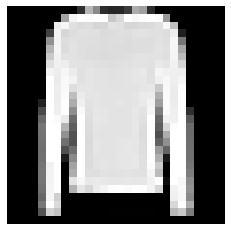

Transformed image


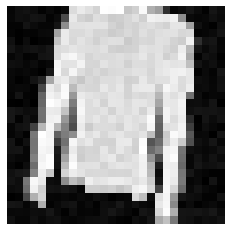

In [40]:
original_image = train_dataset[0][0]
transformed_image = train_trans(original_image)
print(f"Original image shape: {np.array(original_image).shape}")
print(f"transformed shape: {transformed_image.shape}")
#print(transformed_image)

# Plot original image
print('Original')
plt.imshow(original_image, cmap='gray')
plt.axis('off')
plt.show()

# Plot transformed image
print('Transformed image')
plt.imshow(transformed_image.permute([1,2,0]), cmap='gray')
plt.axis('off')
plt.show()

Defining a *DatasetFromSubset* to retrieve a dataset class given the fact that data.random_split returns an item of the class *Subset*.

In [9]:
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x.float(), y

    def __len__(self):
        return len(self.subset)

In [42]:
# Redefine the datasets with the proper transform       

train_dataset = DatasetFromSubset(
    train_dataset, transform=train_trans
)
test_dataset.transform  = test_trans
valid_dataset = DatasetFromSubset(
    valid_dataset, transform=test_trans
)

In the cell below we create the DataLoader objects, we shuffle the training data and choose a batch size of 256 that will be kept fixed throughout the whole classification task. Empirically we found out that it provides good stability to the training process.

In [44]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_dataloader  = DataLoader(dataset=test_dataset,  batch_size=len(test_dataset),  shuffle=False)
valid_dataloader  = DataLoader(dataset=valid_dataset,  batch_size=len(valid_dataset),  shuffle=False)

## Hyperparameter fine tuning
Now, through the validation set, we find the best hyper-paramters for our the model.<br>
Analogously as the first task, we dialed back a little the initial range of parameters, some of them are entirely kept fixed such as the batch size is and some are not implemented at all like the dropout in the fully connected part of the architecture.
<hr>

We optimize:

- Architecture: and maybe above all the parameter's reductor, the architectures tested infact can be divided into two classes, the first two are very similar, the main difference being that in the first we reduce the number of parameters with some **stride** while the other one uses a 2x2 **max pooling** window.<br>
    The second class is made by two networks having fewer feature maps per layer but a bigger depth, the main difference between the two being an adaptive max pooling and a stride parameter at the end.<br>
    The most correct way of operating should have been that of trying all the 4 architectures with all the combinations of the others parameters, in order to reduce the computational complexity though we've done that only for the first 2 architectures while the third and the fourth have been tested with the best combination found for all the other parameters.<br>
    The latter might lead to some wrong assessments on the last two architectures as some hyperparameter might work better with deeper architectures and/or more feature maps; if we'd got some promising results these 2 architectures should be further investigated.<br>
    The concept of making the game fair is replicated as we put care in furnishing the architectures with a comparable number of parameters between them.

- Activation function: We test two different activation functions: ReLU and the Sigmoid function.

- Optimizer: The two different optimizers ar the *Adam* optimizer and *RMSprop*

- Weight decay parameter: Contrary to what we have done with the regression task we do not try out different kind of regularizations but we implement *L2* regardless, what we fine tune is the weight decay parameter of our optimizer, chainging the amount of regularization we implement.

- Learning rate: We look for the best trade-off between stable but slow convergence that has low probability of escaping local minima and fast but unstable convergence with higher probability of escaping local minima.

In [49]:
# Train batch
image_batch, label_batch = next(iter(train_dataloader))
print(f"\nTrain input batch shape: {image_batch.shape}")
print(f"Train label batch shape: {label_batch.shape}")
# Trying the one hot conversion
print('First label =', label_batch[0])


# Test batch
image_batch, label_batch = next(iter(test_dataloader))
print(f"\nTest input batch shape: {image_batch.shape}")
print(f"Test label batch shape: {label_batch.shape}")


Train input batch shape: torch.Size([256, 1, 28, 28])
Train label batch shape: torch.Size([256])
First label = tensor(7)

Test input batch shape: torch.Size([1, 1, 28, 28])
Test label batch shape: torch.Size([1])


### Network definition

In the following cell we define the model that's dependent on the architecture and on the non linear activation function in order to be able to fine tune them.<br>
Furthermore after the convolutional part, the architecture is flattened and a standard, fully connected feed forward neural network that doesn't change across the architectures we test is implemented, having as the output layer 1 neuron for each class (that better prepares us for the application of the softmax function) and ReLu as the activation function.

In [36]:
class conv_net(nn.Module):
    
    def __init__(self, architecture, activation, flatten_param, num_classes):
     
        self.ord_dict = OrderedDict([])
        for i, layer in enumerate(architecture):
            
                
            self.ord_dict.update({f'layer_{i}': \
                layer})

            self.ord_dict.update({f'activation_{i}': \
                    activation})
                
        

        super().__init__()
        
        
        self.conv = nn.Sequential(
            
            self.ord_dict
        )
       

        self.flatten = nn.Flatten(start_dim=1)

        # Linear section
        self.linear = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=flatten_param, out_features=64),
            nn.ReLU(),
            # Second linear layer
            nn.Linear(in_features=64, out_features=num_classes)
        )
        
        
    def forward(self, x): # x is basically the input
        x = self.conv(x.double())
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.linear(x)
        return x

In [19]:
param_1 = [nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), 
                      stride=2, padding=1), #14
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), 
                      stride=2, padding=1), #7 
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), 
                      stride=2, padding=0)] #3

param_2 = [nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=1), #28
            nn.MaxPool2d(kernel_size =2, stride=None, padding=0),#14
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), 
                      stride=1, padding=1), #14
            nn.MaxPool2d(kernel_size =2, stride=None, padding=0),#7
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2, 2), 
                      stride=1, padding=0), 
            nn.MaxPool2d(kernel_size =2, stride=None, padding=0)]     

param_3 = [nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0), #14
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0), #7 
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0), 
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0), 
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0), 
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0), 
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0),
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(3, 3), 
                      stride=1, padding=0),
            nn.AdaptiveMaxPool2d(output_size = 3)
                      ]           


param_4 = [nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0), #14
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0), #7 
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0), 
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0), 
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0), 
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0), 
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), 
                      stride=1, padding=0),
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(2, 2), 
                      stride=3, padding=0)]           



In [52]:
# Definition of 4 test network to see their number of parameters
net1 = conv_net(param_1, nn.ReLU(), flatten_param=32*3*3 ,num_classes=10)
net2 = conv_net(param_2, nn.ReLU(), flatten_param=32*3*3 ,num_classes=10)
net3 = conv_net(param_3, nn.ReLU(), flatten_param=32*3*3 ,num_classes=10)
net4 = conv_net(param_4, nn.ReLU(), flatten_param=32*3*3 ,num_classes=10)

In [53]:
print('Number of parameters of the first architecture:', sum([p.numel() for p  in net1.parameters()]))
print('Number of parameters of the first architecture:', sum([p.numel() for p  in net2.parameters()]))
print('Number of parameters of the first architecture:', sum([p.numel() for p  in net3.parameters()]))
print('Number of parameters of the first architecture:', sum([p.numel() for p  in net4.parameters()]))
# Returns the number of elements in the input tensor

Number of parameters of the first architecture: 25034
Number of parameters of the first architecture: 22474
Number of parameters of the first architecture: 26234
Number of parameters of the first architecture: 24954


### Loss function

As far as the loss function we make the standard choice of the **cross entropy loss** which implies the use of the softmax function.

In [23]:
loss_fn = nn.CrossEntropyLoss()

We define two separete functions that will help us perform the training and test loops

In [21]:
# Training function
def train_epoch(net, dataloader, loss_fn, optimizer_, weight_decay, lr):
    # Set train mode
    net.train()
    for image_batch, label_batch in dataloader:
        
        
        if optimizer_ == 'Adam':
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay = weight_decay)
        elif optimizer_ == 'RMSprop':
            optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay = weight_decay)

        elif optimizer_ == 'SGD_with_momentum':
            optimizer = optim.SGD(net.parameters(), lr=lr, momentum = 0.9, weight_decay = weight_decay)
        # Forward pass
        out = net(image_batch)
        # Evaluate loss
        loss = loss_fn(out, label_batch)
        # Backward pass and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print loss
        print('\t Training loss (single batch):', float(loss.data))

In [22]:
# Testing function
def test_epoch(net, dataloader, loss_fn):
    # Set evaluation mode
    net.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, label_batch in dataloader:
            
            
            # Forward pass
            out = net(image_batch)
            # Append the network output and the original image to the lists
            conc_out.append(out)
            conc_label.append(label_batch)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return conc_out, conc_label, val_loss.data # We return all the outputs, all the labels and the global loss

In [20]:
activations = [nn.ReLU(), nn.Sigmoid()]#, nn.ReLU]#]#, ]#, nn.Tanh()]nn.ReLU
architectures = {'Wide_stride':param_1, 'Wide_pooling': param_2},\
    #'Long_pooling':param_3, 'Long_stride':param_4}
optimizers = ['Adam', 'RMSprop']#'SGD_with_momentum'
weight_decays = [1e-5, 1e-4]
learning_rates = [1e-4, 1e-3]#1e-2, 1e-1]

In [162]:
final_valid_losses = {}

In [234]:
### Training cycle
num_epochs = 5


for activation in activations:
    for optimizer in optimizers:
        for architecture_ in architectures:
            for weight_decay in weight_decays:
                for lr in learning_rates:
                    train_losses = {}
                    val_losses = {}
                    net = conv_net(architectures[architecture_], activation=activation, flatten_param=32*3*3 ,num_classes=10)
                    net = net.double()  
                    for epoch in range(num_epochs):
                        
                        print(f"EPOCH {epoch + 1}/{num_epochs}")
                        ### Training (use the training function)
                        train_epoch(
                            net=net, 
                            dataloader=train_dataloader, 
                            loss_fn=loss_fn, 
                            optimizer_=optimizer, 
                            weight_decay=weight_decay, 
                            lr=lr)
                        
                        ### Train loss (use the TESTING function! We want the train loss but using the network in eval mode and without random transformations)
                        # NOTE: understand why we are doing this!
                        _, _, train_loss = test_epoch(
                            net=net, 
                            dataloader=train_dataloader, 
                            loss_fn=loss_fn)
                        # Print Train loss
                        print(f"\n\n\t TRAIN - EPOCH {epoch + 1}/{num_epochs} - train loss: {train_loss}\n\n")
                        train_losses[f'epoch_{epoch}'] =train_loss

                        ### Validation  (use the testing function)
                        conc_out, conc_label, val_loss = test_epoch(
                            net=net, 
                            dataloader=valid_dataloader, 
                            loss_fn=loss_fn)
                        # Print Validation loss
                        print(f"\n\n\t VALIDATION - EPOCH {epoch + 1}/{num_epochs} - val loss: {val_loss}\n\n")
                        val_losses[f'epoch_{epoch}'] = val_loss
                    final_valid_losses[f'{optimizer}, {activation}, \
                        {architecture_}, weight_decay = {weight_decay}, \
                            learning_rate = {lr}'] = val_losses['epoch_4']
                    print(f'{optimizer}, {activation}, \
                        {architecture_}, weight_decay = {weight_decay}, \
                            learning_rate = {lr}')
                    
                        

In [178]:
filtered_keys = list(map(lambda x:x.replace(' ', '').replace('(', '').replace(')', '')\
    .split(','),list(final_valid_losses.keys())))

In [179]:
valid_df = pd.DataFrame(filtered_keys, columns = ['Optimizers', 'Activation', 'Architecture', \
    'weight_decay', 'Learning_rate'])

In [180]:
valid_df['Losses'] = list(map(lambda x:float(x.numpy()), list(final_valid_losses.values())))
valid_df.head()

,Optimizers,Activation,Architecture,weight_decay,Learning_rate,Losses
0,RMSprop,Sigmoid,Wide_stride,weight_decay=1e-05,learning_rate=0.0001,1.036633
1,RMSprop,Sigmoid,Wide_stride,weight_decay=1e-05,learning_rate=0.001,3.311411
2,RMSprop,Sigmoid,Wide_stride,weight_decay=0.0001,learning_rate=0.0001,0.990805
3,RMSprop,Sigmoid,Wide_stride,weight_decay=0.0001,learning_rate=0.001,1.382798
4,RMSprop,Sigmoid,Wide_pooling,weight_decay=1e-05,learning_rate=0.0001,2.302561


## Fine tuning results

In the following *Pandas* DataFrame we can inqure about the results of our fine tuning procedure performed in the validation set. The main thing that sets apart the best performing models from the lower perfoming ones is the architecture, the one that implements a stride parameter as the parameter reductor performs much better then the one using MaxPooling.<br> 
We could think that that's given by the fact that the first architecture has approximately 3000 more parameters then the second, but we should notice that the third and the fourth, trained using the best combination of the other features perform much closer to the bottom halfs model in spite of having a similar number or even more parameter than the top architecture.

The top models have *ReLU* as the activation function even though the *Sigmoid* function is far more competitive than in the case of the classification task.<br> 
The lower learning rate is also the more featured in the better performing combinations while it seems that for the optimizer it's fairly even.

In [182]:
comparison_df = valid_df.sort_values(by = 'Losses')
comparison_df

,Optimizers,Activation,Architecture,weight_decay,Learning_rate,Losses
22,Adam,ReLU,Wide_stride,weight_decay=0.0001,learning_rate=0.0001,0.766527
20,Adam,ReLU,Wide_stride,weight_decay=1e-05,learning_rate=0.0001,0.842932
18,RMSprop,ReLU,Wide_stride,weight_decay=0.0001,learning_rate=0.0001,0.891606
16,RMSprop,ReLU,Wide_stride,weight_decay=1e-05,learning_rate=0.0001,0.933230
21,Adam,ReLU,Wide_stride,weight_decay=1e-05,learning_rate=0.001,0.950656
10,Adam,Sigmoid,Wide_stride,weight_decay=0.0001,learning_rate=0.0001,0.962752
9,Adam,Sigmoid,Wide_stride,weight_decay=1e-05,learning_rate=0.001,0.968194
17,RMSprop,ReLU,Wide_stride,weight_decay=1e-05,learning_rate=0.001,0.973342
2,RMSprop,Sigmoid,Wide_stride,weight_decay=0.0001,learning_rate=0.0001,0.990805
8,Adam,Sigmoid,Wide_stride,weight_decay=1e-05,learning_rate=0.0001,1.022018


In [183]:
comparison_df.to_csv('Comparison_conv.csv', index = False)

In [39]:
comparison_df = pd.read_csv('Comparison_conv.csv')

### Fine tuning visualization
In the figures below we highlight the performances based on the architecture and on the activation function.

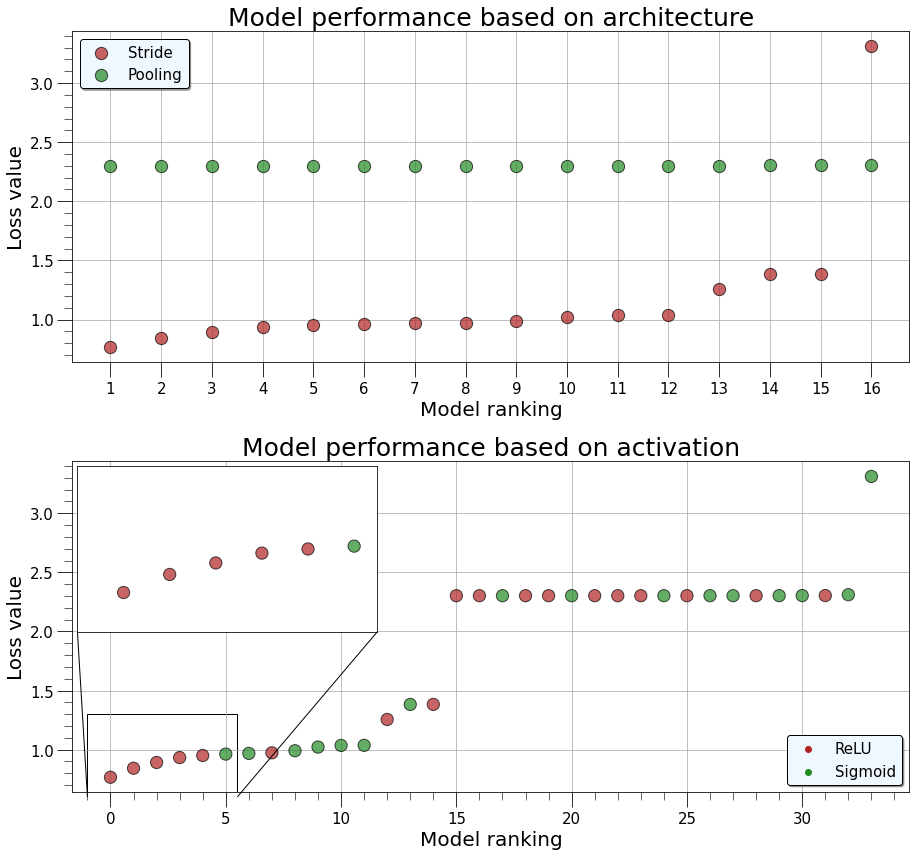

In [233]:
fig, axs = plt.subplots(2, 1, figsize = (15, 14))
ax, ax_ = axs
stride_loss = comparison_df['Losses'][comparison_df['Architecture'] == 'Wide_stride']
pool_loss = comparison_df['Losses'][comparison_df['Architecture'] == 'Wide_pooling']
ax.scatter(range(len(stride_loss)),\
    comparison_df['Losses'][comparison_df['Architecture'] == 'Wide_stride'], color = 'firebrick',\
        s=150, alpha = 0.7, edgecolor = 'black', label = 'Stride', zorder = 2)
ax.scatter(range(len(pool_loss)),\
    comparison_df['Losses'][comparison_df['Architecture'] == 'Wide_pooling'], color = 'forestgreen',\
        s=150, alpha = 0.7, edgecolor = 'black', label = 'Pooling', zorder = 2)


ax.grid(zorder = 1)
ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=False)
ax.tick_params(axis='both', which='major', labelsize=15, length=15)
ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
ax.set_xticks(range(len(stride_loss)))
ax.set_xticklabels(np.arange(len(stride_loss)) + 1)
ax.set_xlabel('Model ranking', fontsize = 20)
ax.set_ylabel('Loss value', fontsize = 20)
ax.set_title('Model performance based on architecture', fontsize = 25)
ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize = 15)

sns.scatterplot(x = range(len(comparison_df)),y=comparison_df['Losses'],\
      hue = comparison_df['Activation'], ax = ax_, palette = ['firebrick', 'forestgreen'], s= 150,\
        edgecolor = 'black', alpha = 0.7, zorder = 2)
ax_.grid(zorder = 1)
ax_.minorticks_on()
ax_.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize = 15, loc='lower right')
ax_.tick_params(axis='both', which='major', labelsize=15, length=15)
ax_.tick_params(axis='both', which='minor', labelsize=15, length=8)
ax_.set_xlabel('Model ranking', fontsize = 20)
ax_.set_ylabel('Loss value', fontsize = 20)
ax_.set_title('Model performance based on activation', fontsize = 25)

axin_ = zoomed_inset_axes(ax_, zoom = 2, loc='upper left',) # zoom = 2
x1, x2 = -1, 5.5
y1, y2 = 0.6, 1.3
axin_.set_xlim(x1, x2)
axin_.set_ylim(y1, y2)
axin_.set_xticks([])
axin_.set_yticks([])

sns.scatterplot(x = range(len(comparison_df)),y=comparison_df['Losses'],\
      hue = comparison_df['Activation'], ax = axin_, palette = ['firebrick', 'forestgreen'], s= 150,\
        edgecolor = 'black', alpha = 0.7, zorder = 2, legend = False)

mark_inset(ax_, axin_, loc1=3, loc2=4, fc="none", ec="0")



fig.subplots_adjust(hspace=0.3)
plt.show()

## Final net implementation

In this section we implement the neural network with the best parameters found, train it in 40 epochs, and test its performances.

In [37]:
final_net = conv_net(param_1, activation=nn.ReLU(),\
    flatten_param=32*3*3 ,num_classes=10)

In [262]:
comparison_df.iloc[0]

Optimizers                       Adam
Activation                       ReLU
Architecture              Wide_stride
weight_decay      weight_decay=0.0001
Learning_rate    learning_rate=0.0001
Losses                       0.766527
Name: 0, dtype: object

In [263]:
# Training cycle
num_epochs = 40




train_losses = {}
test_losses = {}


for epoch in range(num_epochs):
    
    print(f"EPOCH {epoch + 1}/{num_epochs}")
    ### Training (use the training function)
    train_epoch(
        net=final_net, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer_='Adam', 
        weight_decay=0.0001, 
        lr=0.0001)
    
    ### Train loss (use the TESTING function! We want the train loss but using the network in eval mode and without random transformations)
    # NOTE: understand why we are doing this!
    _, _, train_loss = test_epoch(
        net=final_net, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn)
    # Print Train loss
    print(f"\n\n\t TRAIN - EPOCH {epoch + 1}/{num_epochs} - train loss: {train_loss}\n\n")
    train_losses[f'epoch_{epoch}'] =train_loss

    ### Validation  (use the testing function)
    conc_out, conc_label, test_loss = test_epoch(
        net=final_net, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validation loss
    print(f"\n\n\t VALIDATION - EPOCH {epoch + 1}/{num_epochs} - val loss: {test_loss}\n\n")
    test_losses[f'epoch_{epoch}'] = test_loss


    

EPOCH 1/40
	 Training loss (single batch): 2.571005940057717
	 Training loss (single batch): 2.5734027422659937
	 Training loss (single batch): 2.4638089537259957
	 Training loss (single batch): 2.4366753973332256
	 Training loss (single batch): 2.397573364596418
	 Training loss (single batch): 2.369444487832288
	 Training loss (single batch): 2.3985031861221646
	 Training loss (single batch): 2.366738798548378
	 Training loss (single batch): 2.3089974620497906
	 Training loss (single batch): 2.2705191282272454
	 Training loss (single batch): 2.238761149069355
	 Training loss (single batch): 2.2241735289996853
	 Training loss (single batch): 2.2242469656549235
	 Training loss (single batch): 2.1922879555588834
	 Training loss (single batch): 2.126551706210247
	 Training loss (single batch): 2.159576030739444
	 Training loss (single batch): 2.126934583863465
	 Training loss (single batch): 2.130393307791658
	 Training loss (single batch): 1.9955795324838181
	 Training loss (single batch

<center>

| Number of epochs | Test Loss |
|:----------------:|:---------:|
|        40        |    0.64   |


</center>

In [265]:
net_state_dict = final_net.state_dict()
print(net_state_dict.keys())
# Save the state dict to a file
torch.save(net_state_dict, 'conv_net_parameters.torch')

odict_keys(['conv.layer_0.weight', 'conv.layer_0.bias', 'conv.layer_1.weight', 'conv.layer_1.bias', 'conv.layer_2.weight', 'conv.layer_2.bias', 'linear.0.weight', 'linear.0.bias', 'linear.2.weight', 'linear.2.bias'])


In [60]:
net_state_dict = torch.load('conv_net_parameters.torch')
# Update the network parameters
final_net.load_state_dict(net_state_dict)

In [285]:
train_log = list(map(lambda x:float(x.numpy()), list(train_losses.values())))
test_log = list(map(lambda x:float(x.numpy()), list(test_losses.values())))

## Train and test loss progression

From the train and test loss plot we can see how the test loss does keep itself above the training loss but overfitting doesn't seems pathological. <br>
Something we could try to further pull closer together the two curves could be that of trying higher weight decays or further strengthen the regularization transformations performed on the training data.

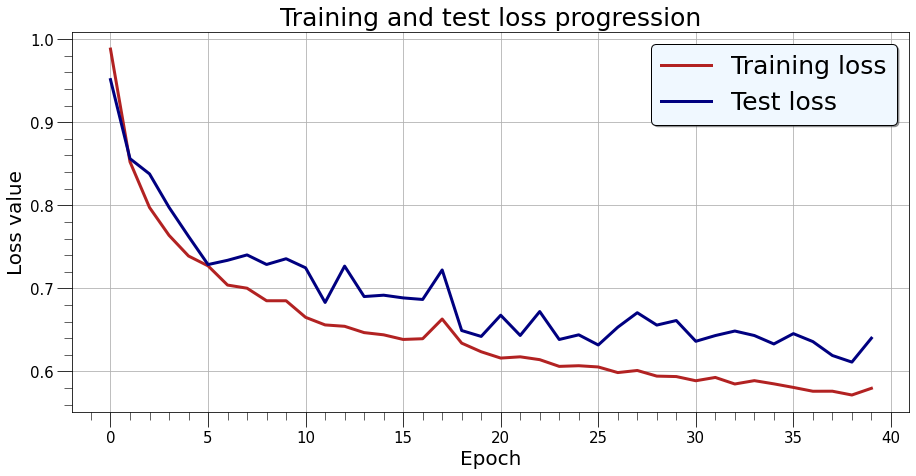

In [304]:
fig, ax = plt.subplots(1, 1, figsize = (15, 7))
ax.plot(train_log, color = 'firebrick', linewidth=3, label='Training loss')
ax.plot(test_log, color = 'navy', linewidth=3, label='Test loss')
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=15, length=15)
ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
ax.set_xlabel('Epoch', fontsize = 20)
ax.set_ylabel('Loss value', fontsize = 20)
ax.set_title('Training and test loss progression', fontsize = 25)
ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize = 25)
ax.grid()
plt.show()

### Accuracy

Computing the accuracy of the model as correctly labeled test sample over total test samples we find an accuracy of 77% that it isn't a great accuracy but testifies how the network works in the right direction and it is able to distinguish between classes. Understandably, as we will se with the confusion matrix, its more frequent mistakes happen with classes that are visually similar between themself.

In [305]:
y_true = conc_label.data.numpy()
y_pred = conc_out.argmax(dim=1).numpy()
y_diff = y_true - y_pred

In [306]:
print('The accuracy of the model is:', len(y_diff[y_diff == 0])/len(y_diff))

The accuracy of the model is: 0.7717


In [322]:
cm = metrics.confusion_matrix(y_true, y_pred)
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']

## Confusion matrix

The confusion matrix is a great tool to understand how a network unravel itself between each class.<br>
We see that a coat is often confused as a shirt or a pullover and a sneaker can be confused for a boot and all of that makes sense.
Furthermore the network never classifies a boot as a t-shirt or a trouser like a sandal as these classes are visually pretty different.

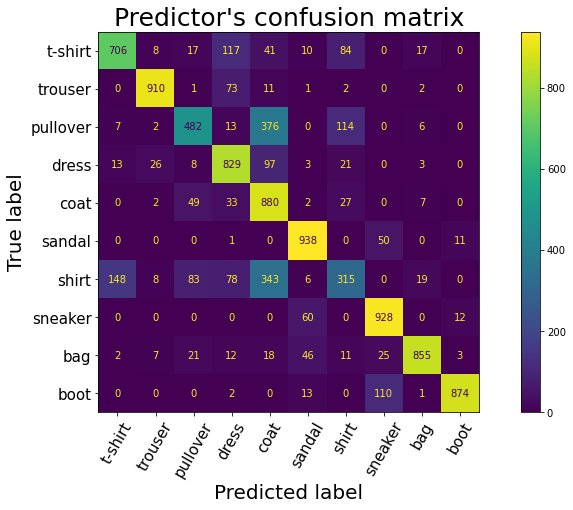

In [337]:
fig, ax = plt.subplots(1, 1, figsize = (15, 7))
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=label_names)
disp.plot(ax = ax)
ax.set_ylabel('True label', fontsize = 20)
ax.set_xlabel('Predicted label', fontsize = 20)
ax.set_xticklabels(labels =label_names, rotation = 60, fontsize = 15)
ax.set_yticklabels(labels =label_names, fontsize = 15)
ax.set_title('Predictor\'s confusion matrix', fontsize = 25)
plt.show()

In [68]:
weights_l1 = final_net.conv[0].weight.data.numpy()
weights_l2 = final_net.conv[2].weight.data.numpy()
weights_l3 = final_net.conv[4].weight.data.numpy()
print('First layer shape:', weights_l1.shape)
print('Second layer shape:', weights_l2.shape)
print('Third layer shape:', weights_l3.shape)

First layer shape: (8, 1, 3, 3)
Second layer shape: (16, 8, 3, 3)
Third layer shape: (32, 16, 3, 3)


## Kernels' visualization

In the following we show the convolutional kernels of our network, the fact that they are 3 by 3 kernels worsens our understanding of what is happening as a larger convolutional field would have provided more clarity.<br>

In the first layer we can see some kernels that suggest that they work as edge detectors and others that might work as corner detectors. In the second one we can spot some on-center and off-center kernels while going deeper and deeper in the layer's depth makes the interpretability increasingly more diffcult.<br>
We find that the presence of some kernerls that have all 0 weights, instead, is harder to interpret and to understand but it may be related to the fact that large portions of the image, where the object is not present, are uniformely black.

In [69]:
def plot_nchw_data(data, h_num, v_num, title, figsize):
    fig, axs = plt.subplots(h_num, v_num, figsize=figsize)
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title, fontsize = 15)
    plt.tight_layout( h_pad=0, w_pad=0)
    plt.show()


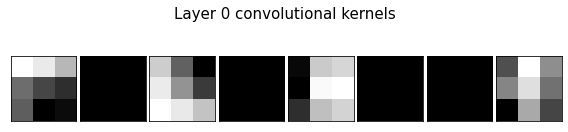

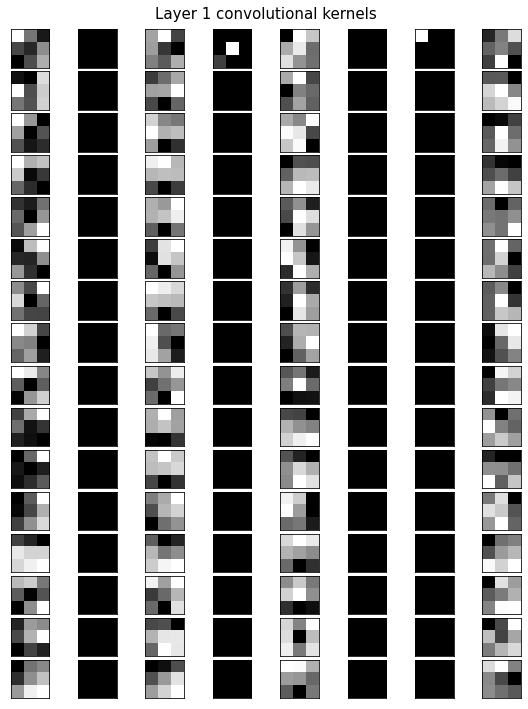

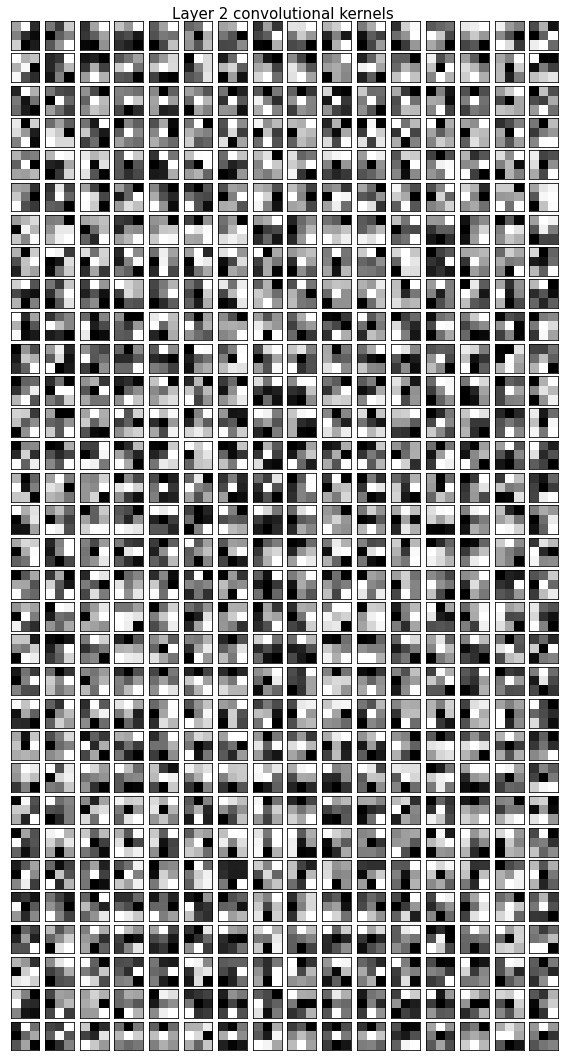

In [73]:
plot_nchw_data(weights_l1, 1, 8, 'Layer 0 convolutional kernels', (8,2))
plot_nchw_data(weights_l2, 16, 8, 'Layer 1 convolutional kernels', (8,10))
plot_nchw_data(weights_l3, 32, 16, 'Layer 2 convolutional kernels', (8, 15))

## Activation's analysis

The feature maps we can give some opinion on what they represent are the first and second as the third is very hard to interpret.<br>
What is seems like is that the network is trying to encode the shape and probably also to separate between the upper part of the shoe and the heel.

In [16]:
# Hook function to call during forward pass
def hook_fn(module, input, output):
    intermediate_outputs.append(output)

# Attach hook function to all the convolutional layers
hook_handles = [] # This list will contains all the handles required to remove the hooks later
hook_handles.append(final_net.conv.activation_0.register_forward_hook(hook_fn))
hook_handles.append(final_net.conv.activation_1.register_forward_hook(hook_fn))
hook_handles.append(final_net.conv.activation_2.register_forward_hook(hook_fn))

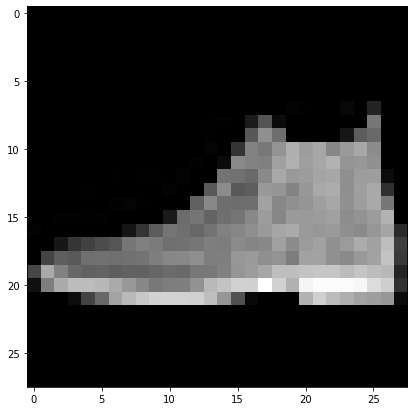

In [41]:
net_input = test_dataset[0][0].unsqueeze(0)

fig, ax = plt.subplots(1, 1, figsize = (15,7))
ax.imshow(test_dataset[0][0].squeeze().numpy(), cmap='gray')
plt.show()

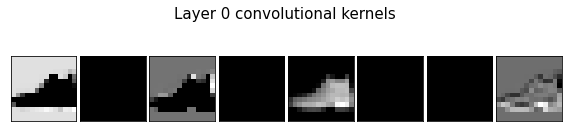

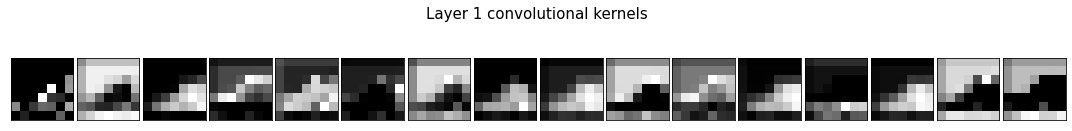

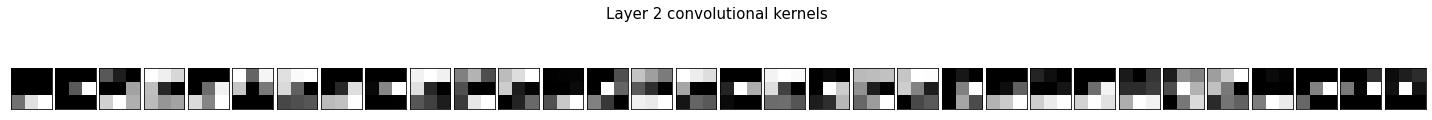

In [66]:
final_net.eval()
with torch.no_grad():
    intermediate_outputs = []
    out = final_net(net_input)
    # Now the intermediate_outputs list contains the intermediate outputs thanks to the hook function

# Analyze intermediate outputs
#for layer_num, intermediate_output in enumerate(intermediate_outputs):
 #   intermediate_output = intermediate_output.data.numpy()
    # Plot
plot_nchw_data(intermediate_outputs[0], 1, 8, 'Layer 0 convolutional kernels', (8,2))
plot_nchw_data(intermediate_outputs[3], 1, 16, 'Layer 1 convolutional kernels', (15,2))
plot_nchw_data(intermediate_outputs[6], 1, 32, 'Layer 2 convolutional kernels', (20,2))

In [74]:
for handle in hook_handles:
  handle.remove()

# Further improvements and follow-ups

In this part of the notebook we implement some further follow-ups to our analysis.<br>
The first thing we do is to test the approach done in [homework_2](../homework_2/homework_2.ipynb) could solve some of the problems in our classifier.

More specifically we looked at the the very good generalization properties obtained in the networks of [homework_2](../homework_2/homework_2.ipynb) and we tryed to replicate that.<br>
We followed the same exact procedure of [homework_2](../homework_2/homework_2.ipynb) in terms of building the train dataloader: we applied the same exact transformations explained in the notebook and concatenated the augmentation set with the training one, once again, this procedure is explained in detail in the [homework_2](../homework_2/homework_2.ipynb)'s notebook.<br>

After building the DataLoader object we train the same architecture with the same hyper-parameters of the final model defined above. <br>
In summarizing our results we did not only highlight the performancences after the whole 40 epochs but we did that also after 26 epochs. The latter is because now the the training dataset has $\dfrac{3}{2}$ of the data it had before, after 26 epochs then the net has seen a number of samples pretty similar to the number exploited before the follow-up section.

From the results showed in the following cells we notice encouraging improvements from the previous set-up.<br>
First of all it seems like we don't suffer from over-fitting anymore as the test loss constantly stays below the training one. Furthermore the overall loss value is smaller already at the 26 epoch mark.

One other thing we like of this implementation is that far less kernels learn all 0 weights

In [4]:
# set all the seeds at once
torch.manual_seed(123)
random.seed(123)
np.random.seed(1)

In [6]:
train_dataset = torchvision.datasets.FashionMNIST('Mnist_dataset', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('Mnist_dataset', train=False, download=True)

In [7]:
class rand_noise(object):
        
    def __call__(self, image):
        self.random = torch.rand_like(torch.tensor(np.zeros((28, 28))))
        return image + self.random/5

In [8]:
# Train transformation pipeline

aug_trans = transforms.Compose([
         
        transforms.RandomRotation([-45, 45]),
        
        transforms.RandomResizedCrop(size = 28, scale=(0.9, 1)),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomInvert(p=0.3),
        
        transforms.ToTensor(),
        rand_noise()
        
        ])

In [10]:
train_set_size = int(len(train_dataset) * 0.8)
validation_set_size = len(train_dataset) - train_set_size
train_dataset, validation_set = data.random_split(train_dataset, [train_set_size, validation_set_size],\
    generator=torch.Generator().manual_seed(123))

In [11]:
aug_idx = random.sample(range(train_set_size), k = int((train_set_size)*0.5)) #samples without replacement
aug_dataset = torch.utils.data.Subset(train_dataset, aug_idx)

In [14]:
# Redefine the datasets with the proper transform       


train_dataset  = DatasetFromSubset(
    train_dataset, transform=test_trans)
validation_set  = DatasetFromSubset(
    validation_set, transform=test_trans)
test_dataset.transform  = test_trans
aug_dataset = DatasetFromSubset(
    aug_dataset, transform=aug_trans
)

In [15]:
# Final training set obtaines by concatenating the training and the augmented dataset
final_train = torch.utils.data.ConcatDataset([train_dataset, aug_dataset])

In [39]:
train_dataloader = DataLoader(final_train, batch_size=256, shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataloader), shuffle=False)

In [38]:
final_net = conv_net(param_1, activation=nn.ReLU(),\
    flatten_param=32*3*3 ,num_classes=10)

In [41]:
final_net = final_net.double()

In [42]:
# Training cycle
num_epochs = 40




train_losses = {}
test_losses = {}


for epoch in range(num_epochs):
    
    print(f"EPOCH {epoch + 1}/{num_epochs}")
    ### Training (use the training function)
    train_epoch(
        net=final_net, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer_='Adam', 
        weight_decay=0.0001, 
        lr=0.0001)
    
    ### Train loss (use the TESTING function! We want the train loss but using the network in eval mode and without random transformations)
    # NOTE: understand why we are doing this!
    _, _, train_loss = test_epoch(
        net=final_net, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn)
    # Print Train loss
    print(f"\n\n\t Train - epoch {epoch + 1}/{num_epochs} - train loss: {train_loss}\n\n")
    train_losses[f'epoch_{epoch}'] =train_loss

    ### Validation  (use the testing function)
    conc_out, conc_label, test_loss = test_epoch(
        net=final_net, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validation loss
    print(f"\n\n\t Validation - epoch {epoch + 1}/{num_epochs} - val loss: {test_loss}\n\n")
    test_losses[f'epoch_{epoch}'] = test_loss


    

EPOCH 1/40
	 Training loss (single batch): 2.3052121397237544
	 Training loss (single batch): 2.304766714831495
	 Training loss (single batch): 2.302022301620715
	 Training loss (single batch): 2.303357540453243
	 Training loss (single batch): 2.3037193785250634
	 Training loss (single batch): 2.2985795981256953
	 Training loss (single batch): 2.3048947044425123
	 Training loss (single batch): 2.300923878918265
	 Training loss (single batch): 2.3027375813051916
	 Training loss (single batch): 2.3015226860341222
	 Training loss (single batch): 2.304728830363114
	 Training loss (single batch): 2.3075770987879216
	 Training loss (single batch): 2.3028532790188447
	 Training loss (single batch): 2.304011005938678
	 Training loss (single batch): 2.299687440674971
	 Training loss (single batch): 2.299539019269854
	 Training loss (single batch): 2.3044744110597795
	 Training loss (single batch): 2.303891909652407
	 Training loss (single batch): 2.2977237317572596
	 Training loss (single batch

In [46]:
train_loss_40 = train_losses['epoch_39'].numpy()
train_loss_26 = train_losses['epoch_25'].numpy()

test_loss_40 = test_losses['epoch_39'].numpy()
test_loss_26 = test_losses['epoch_25'].numpy()

print('Train loss at epoch 40:', train_loss_40)
print('Train loss at epoch 26:', train_loss_26)

print('Test loss at epoch 40:', test_loss_40)
print('Test loss at epoch 26:', test_loss_26)

Train loss at epoch 40: 0.601697154122046
Train loss at epoch 26: 0.6499243605761494
Test loss at epoch 40: 0.46709310022101774
Test loss at epoch 26: 0.5028786313514666


<center>

| **Number of epochs** | **Training Loss** | **Test Loss** |
|:--------------------:|:-------------------:|:-------------:|
|          40          |        0.60       |      0.47     |
|          26          |        0.64       |      0.50     |

</center>

In [48]:
train_log = list(map(lambda x:float(x.numpy()), list(train_losses.values())))
test_log = list(map(lambda x:float(x.numpy()), list(test_losses.values())))

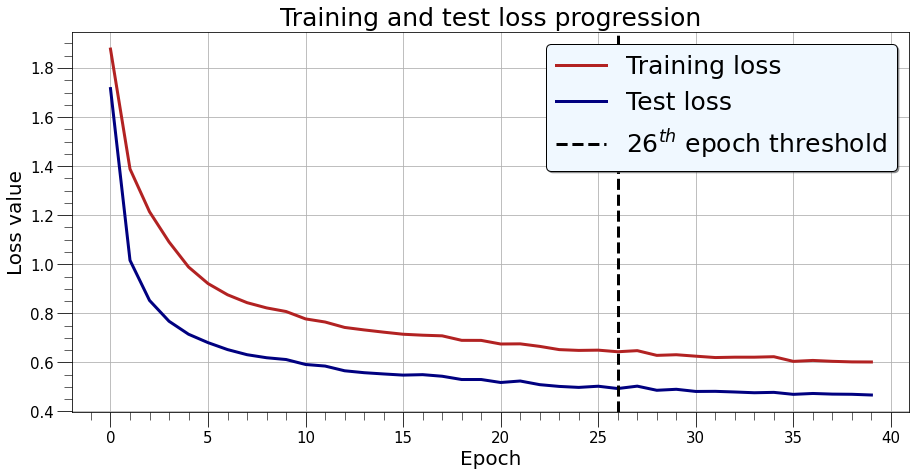

In [54]:
fig, ax = plt.subplots(1, 1, figsize = (15, 7))
ax.plot(train_log, color = 'firebrick', linewidth=3, label='Training loss')
ax.plot(test_log, color = 'navy', linewidth=3, label='Test loss')
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=15, length=15)
ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
ax.set_xlabel('Epoch', fontsize = 20)
ax.set_ylabel('Loss value', fontsize = 20)
ax.set_title('Training and test loss progression', fontsize = 25)
ax.axvline(26, linewidth = 3, color = 'black', linestyle = '--',\
     label = '$26^{th}$ epoch threshold')
ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize = 25)
ax.grid()
plt.show()

In [55]:
y_true = conc_label.data.numpy()
y_pred = conc_out.argmax(dim=1).numpy()
y_diff = y_true - y_pred

In [56]:
print('The accuracy of the model is:', len(y_diff[y_diff == 0])/len(y_diff))

The accuracy of the model is: 0.8353


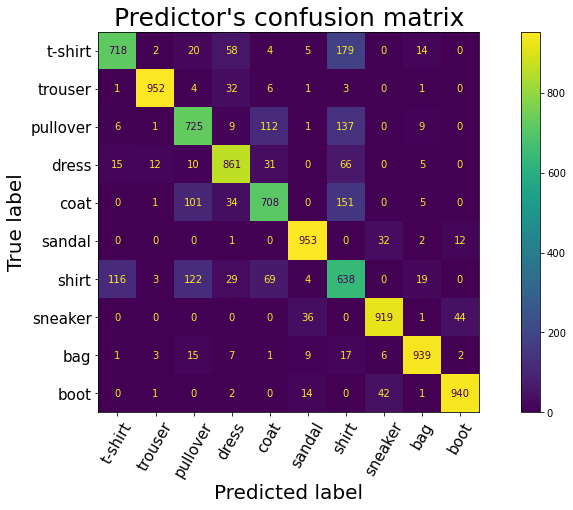

In [58]:
cm = metrics.confusion_matrix(y_true, y_pred)
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']


fig, ax = plt.subplots(1, 1, figsize = (15, 7))
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=label_names)
disp.plot(ax = ax)
ax.set_ylabel('True label', fontsize = 20)
ax.set_xlabel('Predicted label', fontsize = 20)
ax.set_xticklabels(labels =label_names, rotation = 60, fontsize = 15)
ax.set_yticklabels(labels =label_names, fontsize = 15)
ax.set_title('Predictor\'s confusion matrix', fontsize = 25)
plt.show()

In [59]:
weights_l1 = final_net.conv[0].weight.data.numpy()
weights_l2 = final_net.conv[2].weight.data.numpy()
weights_l3 = final_net.conv[4].weight.data.numpy()
print('First layer shape:', weights_l1.shape)
print('Second layer shape:', weights_l2.shape)
print('Third layer shape:', weights_l3.shape)

First layer shape: (8, 1, 3, 3)
Second layer shape: (16, 8, 3, 3)
Third layer shape: (32, 16, 3, 3)


In [60]:
def plot_nchw_data(data, h_num, v_num, title, figsize):
    fig, axs = plt.subplots(h_num, v_num, figsize=figsize)
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title, fontsize = 15)
    plt.tight_layout( h_pad=0, w_pad=0)
    plt.show()


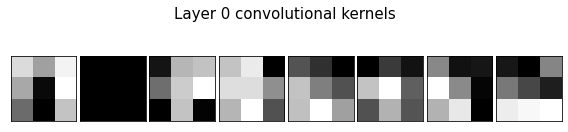

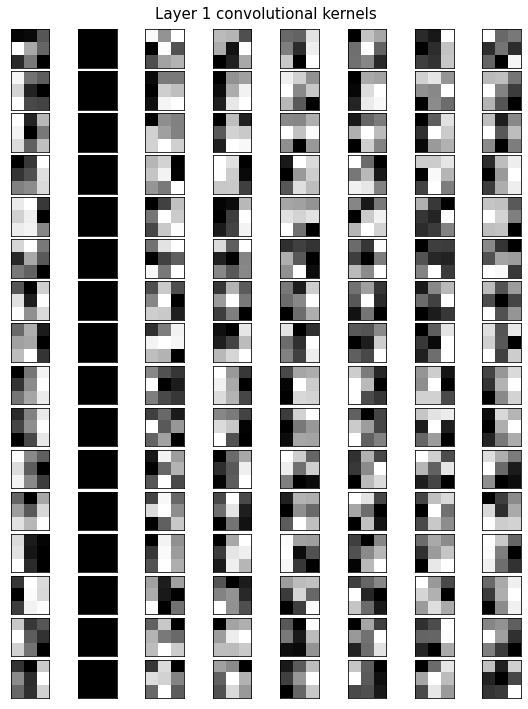

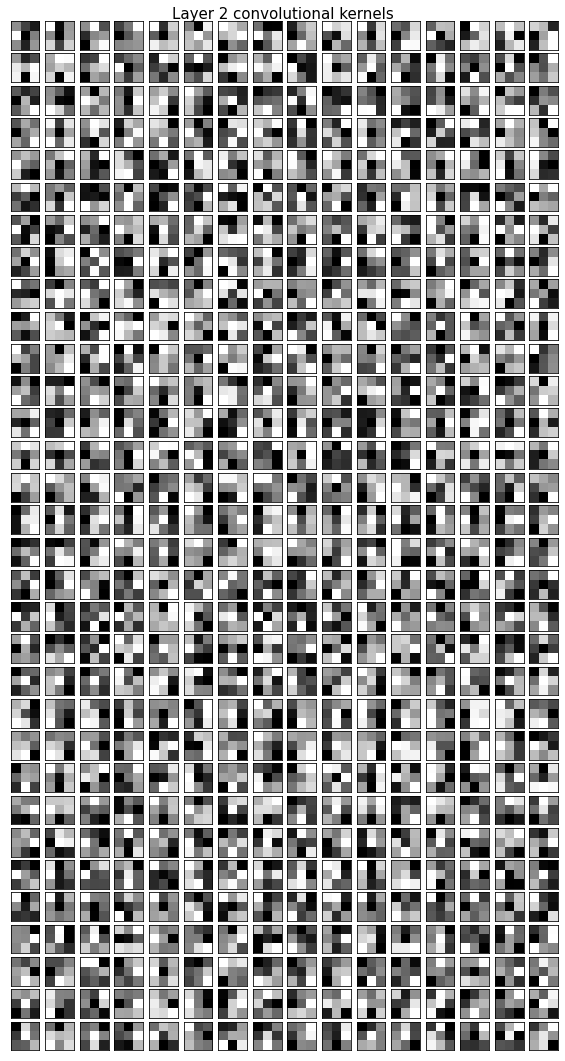

In [61]:
plot_nchw_data(weights_l1, 1, 8, 'Layer 0 convolutional kernels', (8,2))
plot_nchw_data(weights_l2, 16, 8, 'Layer 1 convolutional kernels', (8,10))
plot_nchw_data(weights_l3, 32, 16, 'Layer 2 convolutional kernels', (8, 15))

In [62]:
# Hook function to call during forward pass
def hook_fn(module, input, output):
    intermediate_outputs.append(output)

# Attach hook function to all the convolutional layers
hook_handles = [] # This list will contains all the handles required to remove the hooks later
hook_handles.append(final_net.conv.activation_0.register_forward_hook(hook_fn))
hook_handles.append(final_net.conv.activation_1.register_forward_hook(hook_fn))
hook_handles.append(final_net.conv.activation_2.register_forward_hook(hook_fn))

In [ ]:
for handle in hook_handles:
  handle.remove()

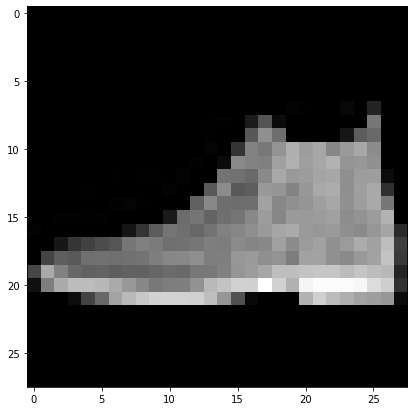

In [64]:
net_input = test_dataset[0][0].unsqueeze(0)

fig, ax = plt.subplots(1, 1, figsize = (15,7))
ax.imshow(test_dataset[0][0].squeeze().numpy(), cmap='gray')
plt.show()

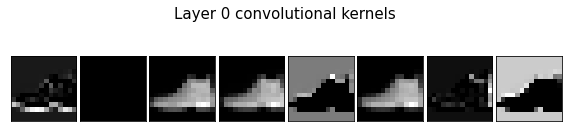

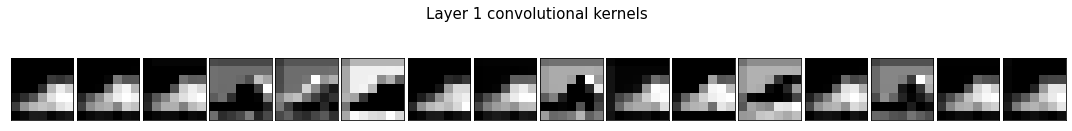

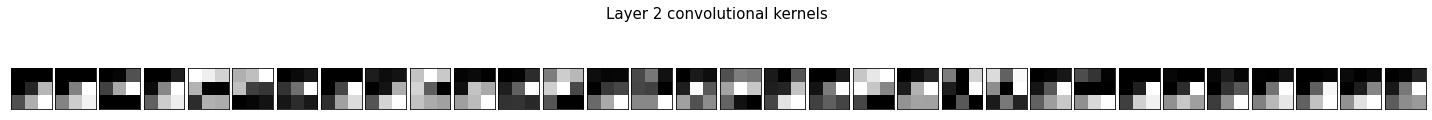

In [65]:
final_net.eval()
with torch.no_grad():
    intermediate_outputs = []
    out = final_net(net_input)
    # Now the intermediate_outputs list contains the intermediate outputs thanks to the hook function

# Analyze intermediate outputs
#for layer_num, intermediate_output in enumerate(intermediate_outputs):
 #   intermediate_output = intermediate_output.data.numpy()
    # Plot
plot_nchw_data(intermediate_outputs[0], 1, 8, 'Layer 0 convolutional kernels', (8,2))
plot_nchw_data(intermediate_outputs[3], 1, 16, 'Layer 1 convolutional kernels', (15,2))
plot_nchw_data(intermediate_outputs[6], 1, 32, 'Layer 2 convolutional kernels', (20,2))

In [66]:
for handle in hook_handles:
  handle.remove()

## Glorot initialization

As far as the regression task is concerned, as a follow-up we try to add one feature to our network we did not explore i the cross validation. We try to infact to initialize our weights with the *Glorot* initialization to see if a different initialization impacts significantly a net with so few neurons.<br>

What we notice is that using *Glorot* as the generalization fuctiondoes not improve our performances, that's may be helped by the fact that the default *PyTorch* initialization function `torch.nn.init.kaiming_uniform_` has similar features and goals compared to *Glorot*.

In [ ]:
final_train_sample = RegressionDataset(train_df, transform= \
                                lambda x: (torch.Tensor([x[0]]).float(),torch.Tensor([x[1]]).float()))
# Now we shuffle
final_train_data = DataLoader(final_train_sample, batch_size=4, shuffle=True)

final_test_sample = RegressionDataset(test_df, transform= \
                                lambda x: (torch.Tensor([x[0]]).float(),torch.Tensor([x[1]]).float()))
# Now we shuffle
final_test_data = DataLoader(final_test_sample, batch_size=len(final_test_sample), shuffle=False)

In [34]:
final_model = Net(architecures['Wide'], activation=activations['LeakyReLU'])

In [35]:
final_optimizer = optim.RMSprop(final_model.parameters(), lr = 0.01)


In [36]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

In [37]:
final_model.apply(init_weights)

Net(
  (neural_net): Sequential(
    (linear_0): Linear(in_features=1, out_features=10, bias=True)
    (activation_1): LeakyReLU(negative_slope=0.01)
    (linear_1): Linear(in_features=10, out_features=10, bias=True)
    (activation_2): LeakyReLU(negative_slope=0.01)
    (linear_2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [38]:
### TRAINING LOOP
num_epochs = 3000
train_loss_log = []
val_loss_log = []
non_improving = 0
val_loss_mean = np.Inf
epoch_num = 0
while non_improving < 300:
    epoch_num += 1
#for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    # TRAIN
    train_loss= []
    final_model.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
    for sample_batched in final_train_data:
        
        x_batch = sample_batched[0]
        label_batch = sample_batched[1]

        # Forward pass
        out = final_model(x_batch)
        l1_penalty = 1e-3 * sum([p.abs().sum() for name, p in final_model.named_parameters()\
                                            if 'bias' not in name])
        l2_penalty = 1e-3 * sum([(p**2).sum() for name, p in final_model.named_parameters()\
            if 'bias' not in name])
        # Compute loss
        loss = l1_loss(out, label_batch)

        loss += l1_penalty + l2_penalty
        # Backpropagation
        final_model.zero_grad()
        loss.backward()

        # Update the weights
        final_optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().numpy() # we detach it from the computational graph
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    val_loss= []
    final_model.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking, we don't want to update the weights
        for sample_batched in final_test_data:
            
            x_batch = sample_batched[0]
            label_batch = sample_batched[1]
            
            # Forward pass
            out = final_model(x_batch)
            l1_penalty = 1e-3 * sum([p.abs().sum() for name, p in final_model.named_parameters()\
                                            if 'bias' not in name])
            l2_penalty = 1e-3 * sum([(p**2).sum() for name, p in final_model.named_parameters()\
                if 'bias' not in name])
            # Compute loss
            loss = l1_loss(out, label_batch)

            loss += l1_penalty + l2_penalty

            

            # Save val loss for this batch
            loss_batch = loss.detach().numpy()
            val_loss.append(loss_batch)

        # Save average validation loss
        if np.mean(val_loss) > val_loss_mean:
            non_improving +=1
        val_loss_mean = np.mean(val_loss)
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss_mean)}")
        val_loss_log.append(val_loss_mean)
    


#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 1.9099572896957397
AVERAGE VAL LOSS: 1.4616276025772095
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 1.2600071430206299
AVERAGE VAL LOSS: 1.2893645763397217
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 1.2371770143508911
AVERAGE VAL LOSS: 1.127274513244629
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 1.244916558265686
AVERAGE VAL LOSS: 1.2359899282455444
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 1.2321587800979614
AVERAGE VAL LOSS: 1.0275368690490723
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 1.1356875896453857
AVERAGE VAL LOSS: 1.0384249687194824
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 1.1215951442718506
AVERAGE VAL LOSS: 0.9384249448776245
#################
# EPOCH 8
#################
AVERAGE TRAIN LOSS: 1.063859462738037
AVERAGE VAL LOSS: 1.0983461141586304
#################
# EPOCH 9

In [44]:
print('Test loss:', val_loss_log[-1], '\nTrain loss', train_loss_log[-1])

Test loss: 0.54561347 
Train loss 0.5093153


In [42]:
print('The final number of epochs is: ', epoch_num)

The final number of epochs is:  601


<center>

| Number of epochs | Training Loss | Test Loss |
|:----------------:|:-------------:|-----------|
|        601       |      0.51     |    0.54   |


</center>